In [167]:
import os

# Configura la variable de entorno para que las llamadas CUDA sean síncronas
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize
from sklearn.model_selection import  StratifiedKFold, train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from umap import UMAP
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<Axes: xlabel='class'>

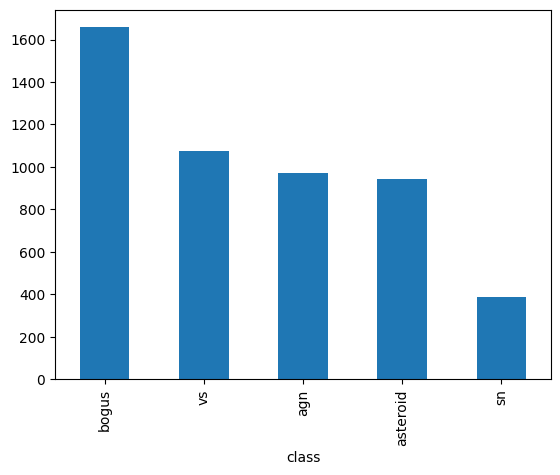

In [169]:

df=pd.read_pickle('2025A_AS4501_HW3.pkl')           #cargamos el archivo
df_label=df[df['class']!='Unkwown']                 #creamos un dataframe solo con los objetos etiquetados
df_label['class'].value_counts().plot.bar()         #histograma de las clases


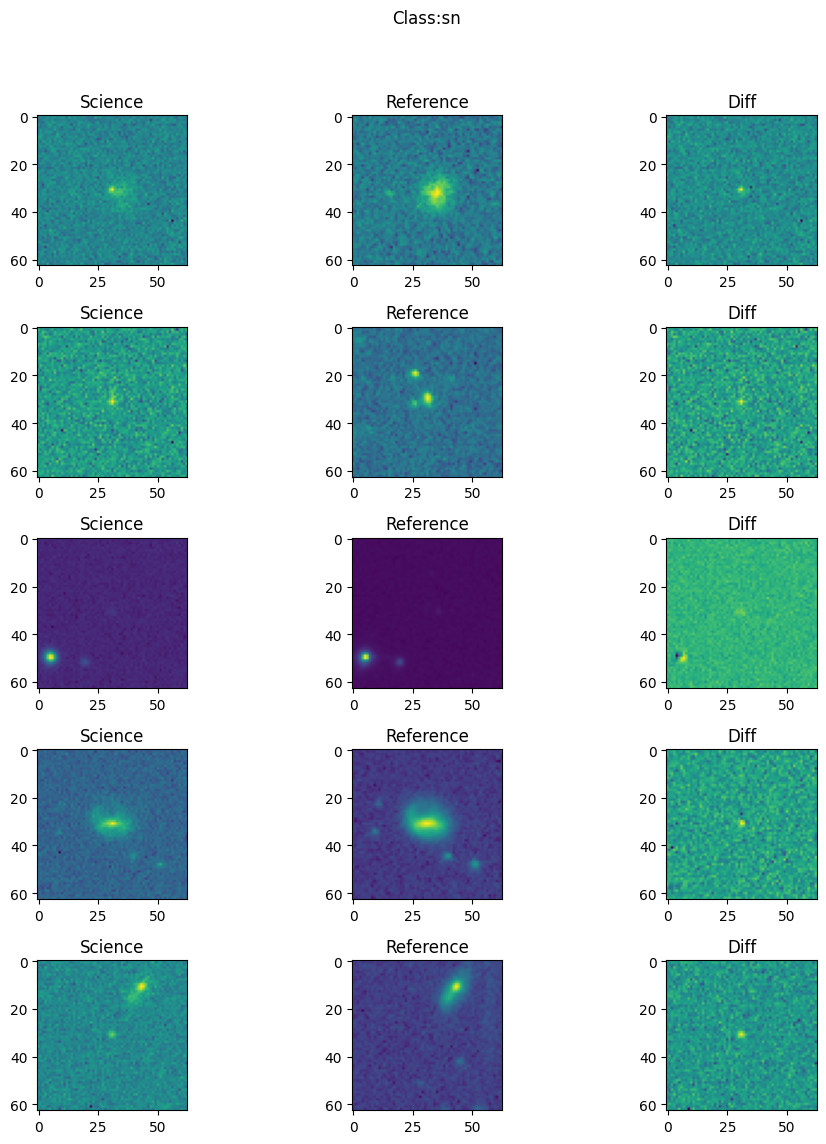

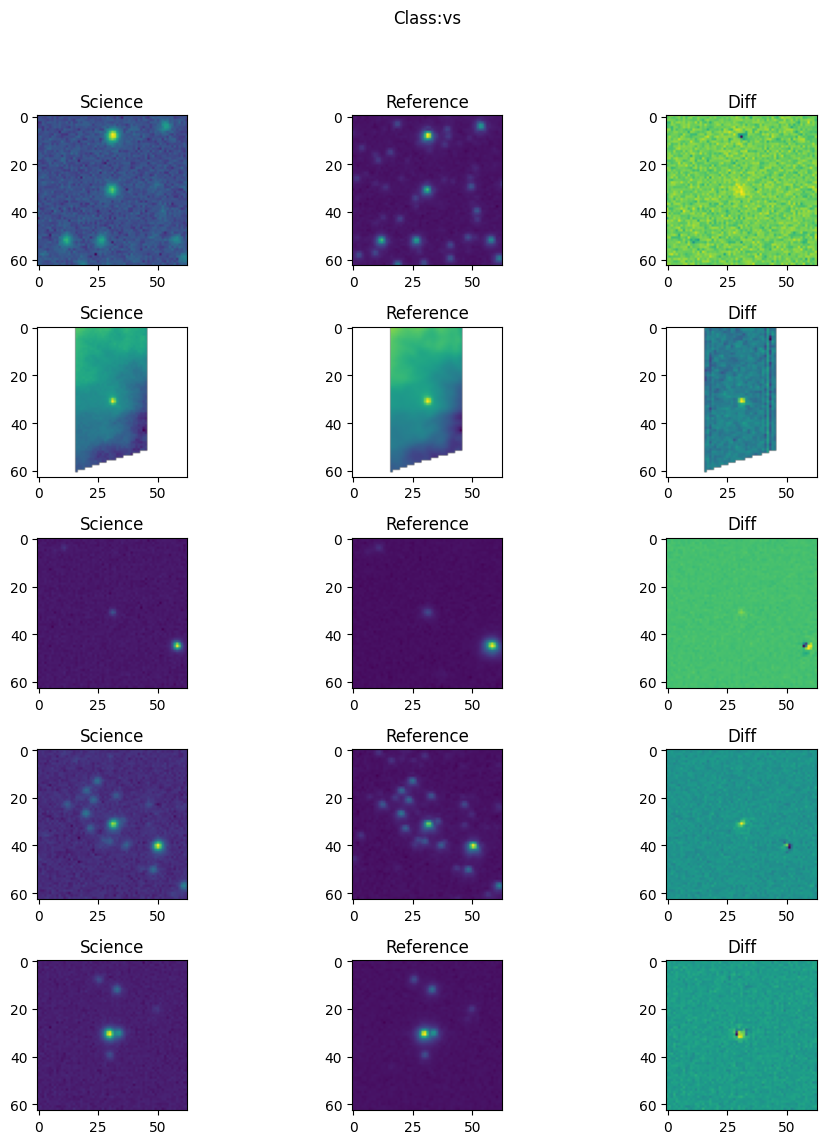

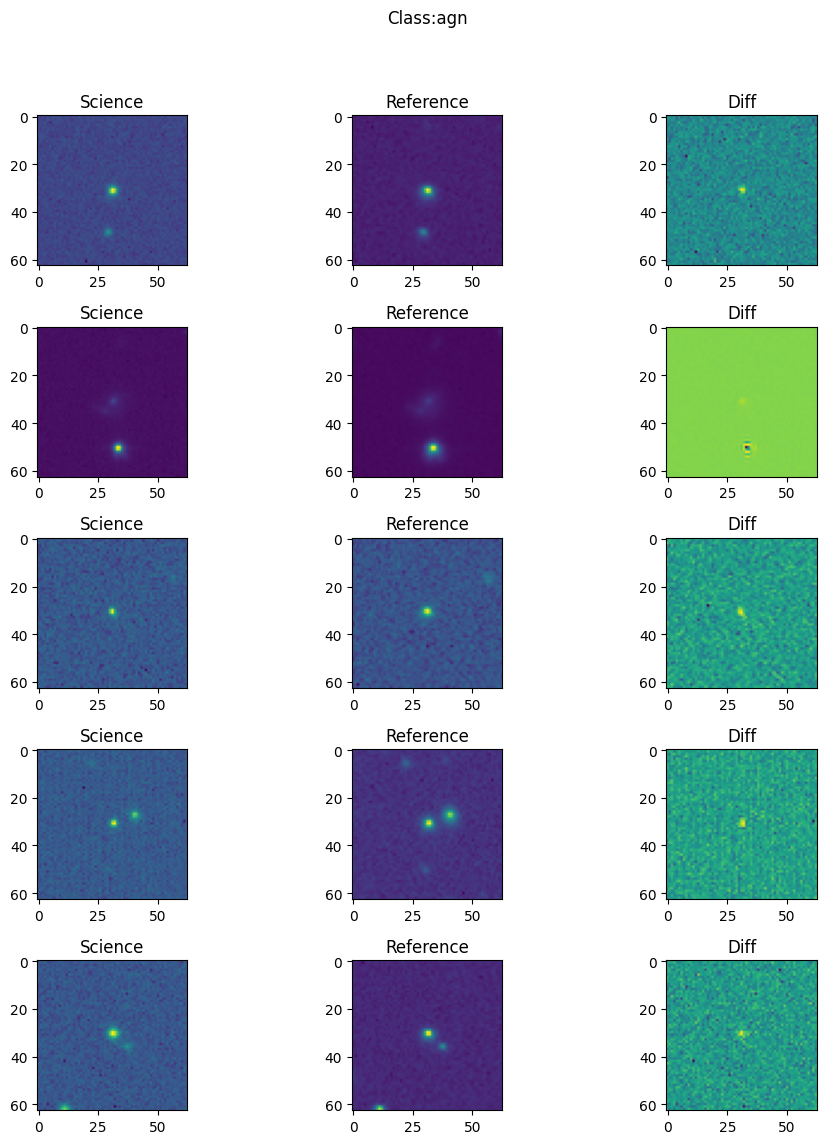

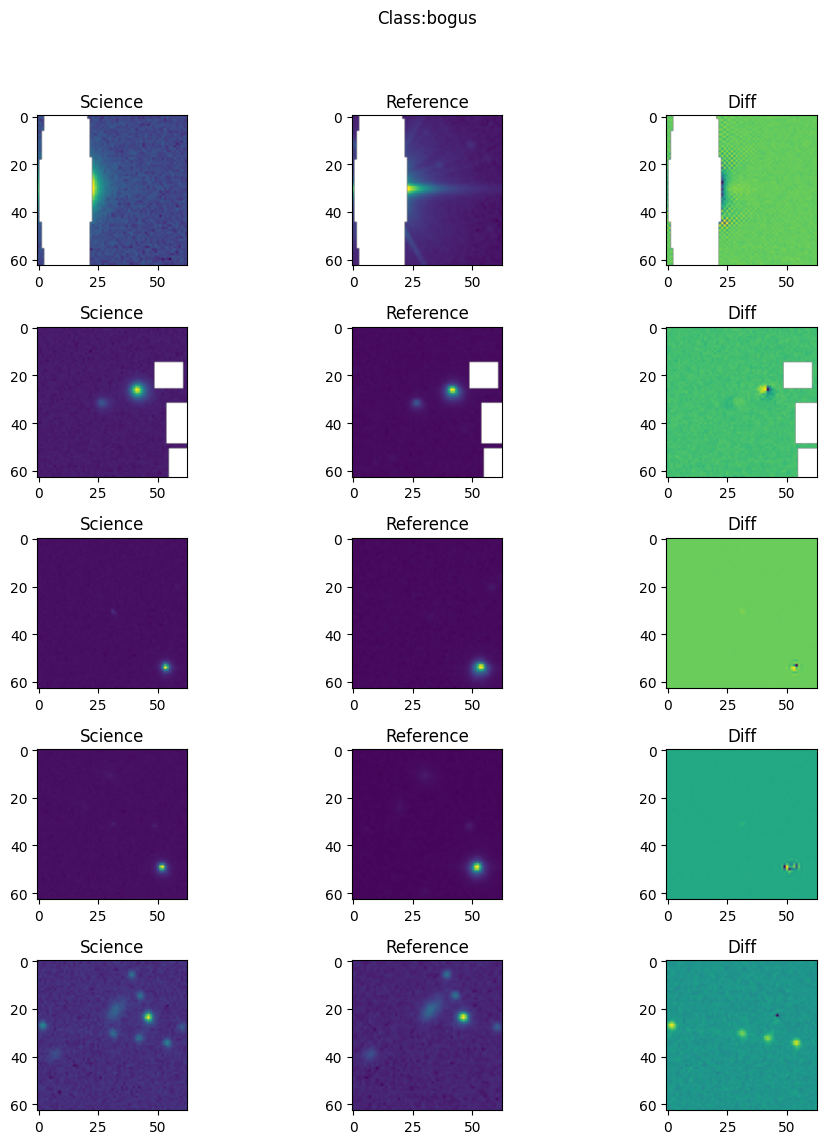

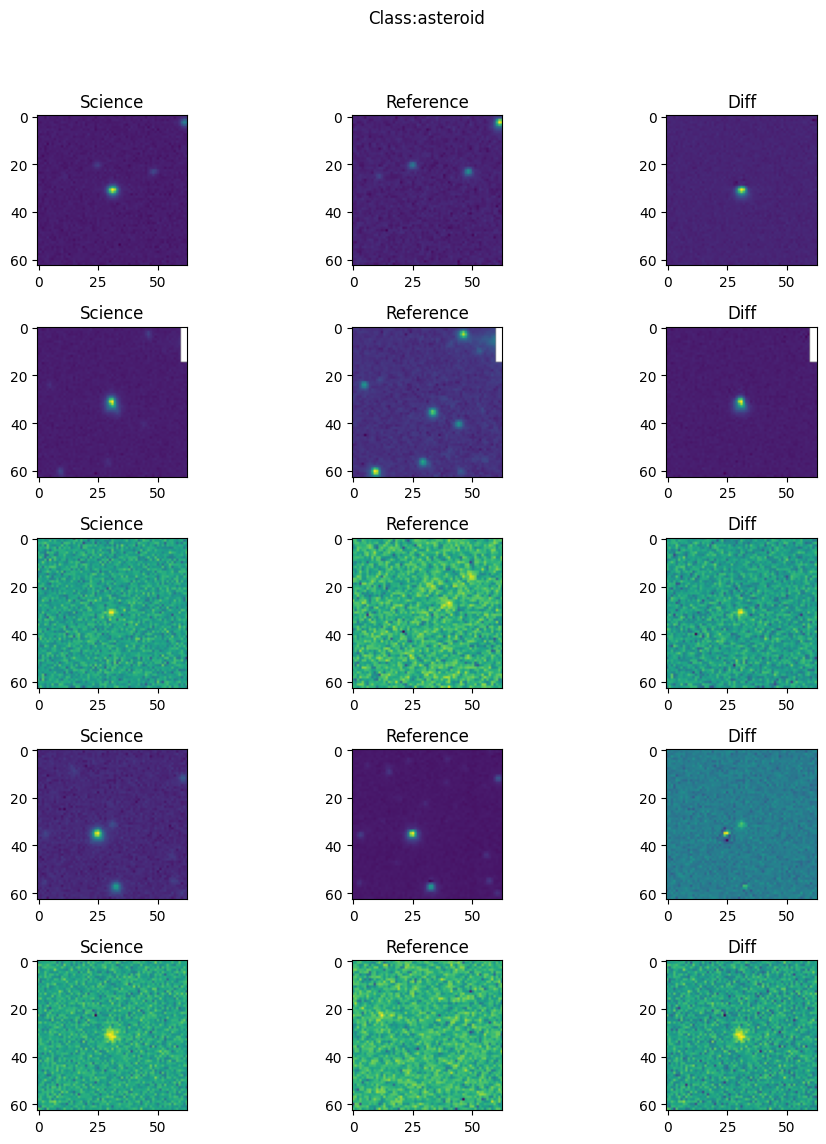

In [170]:
#Visualizamos 5 objetos aleatorios por cada clase
for cls in df_label['class'].unique():
    sample=df_label[df_label['class']==cls].sample(5,random_state=68884)

    fig, ax =plt.subplots(5,3,figsize=(10,12))
    fig.suptitle(f'Class:{cls}')
    for i , (_,r) in enumerate(sample.iterrows()):
        img_sc=r['science']
        norm_sc=ImageNormalize(img_sc,interval=MinMaxInterval(),stretch=SqrtStretch())
        ax[i,0].imshow(img_sc,norm=norm_sc,cmap='viridis')
        ax[i,0].set_title('Science')


        img_ref=r['reference']
        norm_ref=ImageNormalize(img_ref,interval=MinMaxInterval(),stretch=SqrtStretch())
        ax[i,1].imshow(img_ref,norm=norm_ref,cmap='viridis')
        ax[i,1].set_title('Reference')


        img_diff=r['diff']
        norm_diff=ImageNormalize(img_diff,interval=MinMaxInterval(),stretch=SqrtStretch())
        ax[i,2].imshow(img_diff,norm=norm_diff,cmap='viridis')
        ax[i,2].set_title('Diff')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [171]:
def preprocess(img):
    #Recorte central de un tamaño de 16x16 px
    x,y=img.shape
    x_i=(x-16)//2
    y_i=(y-16)//2
    cropp_img=img[x_i:x_i+16,y_i:y_i+16]
    #Reemplazamos los valores NaN por la mediana
    if np.isnan(cropp_img).any():
        
        median_val = np.nanmedian(cropp_img)
        cropp_img = np.nan_to_num(cropp_img, nan=median_val)
    #Normalizacion
    a=np.min(cropp_img)
    b=np.max(cropp_img)
    return (cropp_img-a)/(b-a)
#creamos una nueva columna con las imagenes procesadas y apiladas quedando una dim (3,16,16)
df['processed_img'] = [
    np.stack([s_img, r_img, d_img], axis=0)
    for s_img, r_img, d_img in zip(df['science'].apply(preprocess), df['reference'].apply(preprocess), df['diff'].apply(preprocess))
]



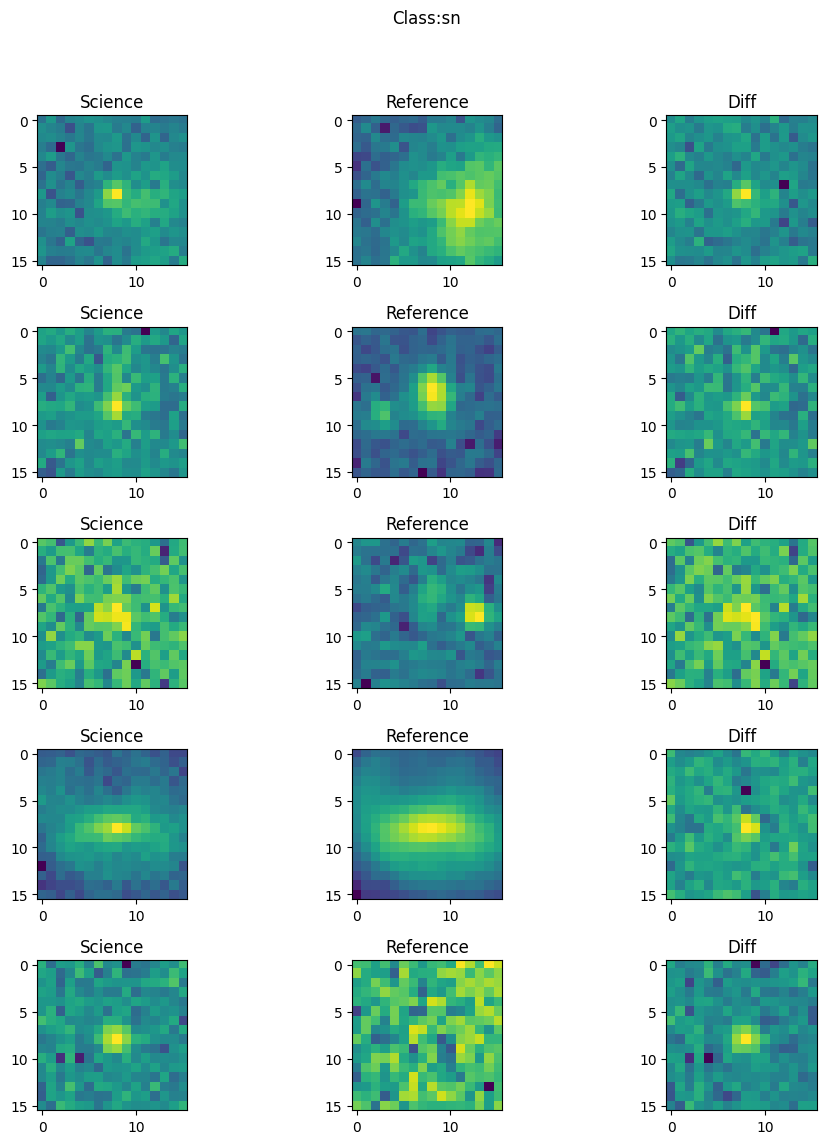

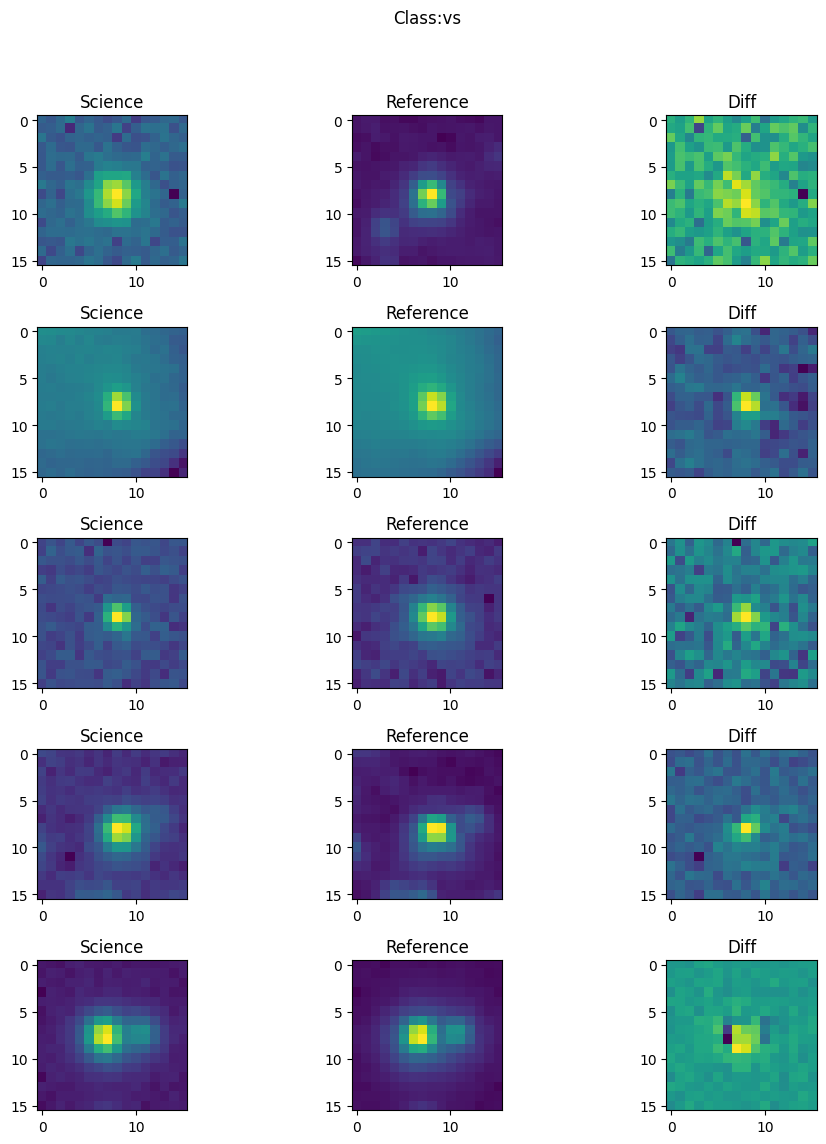

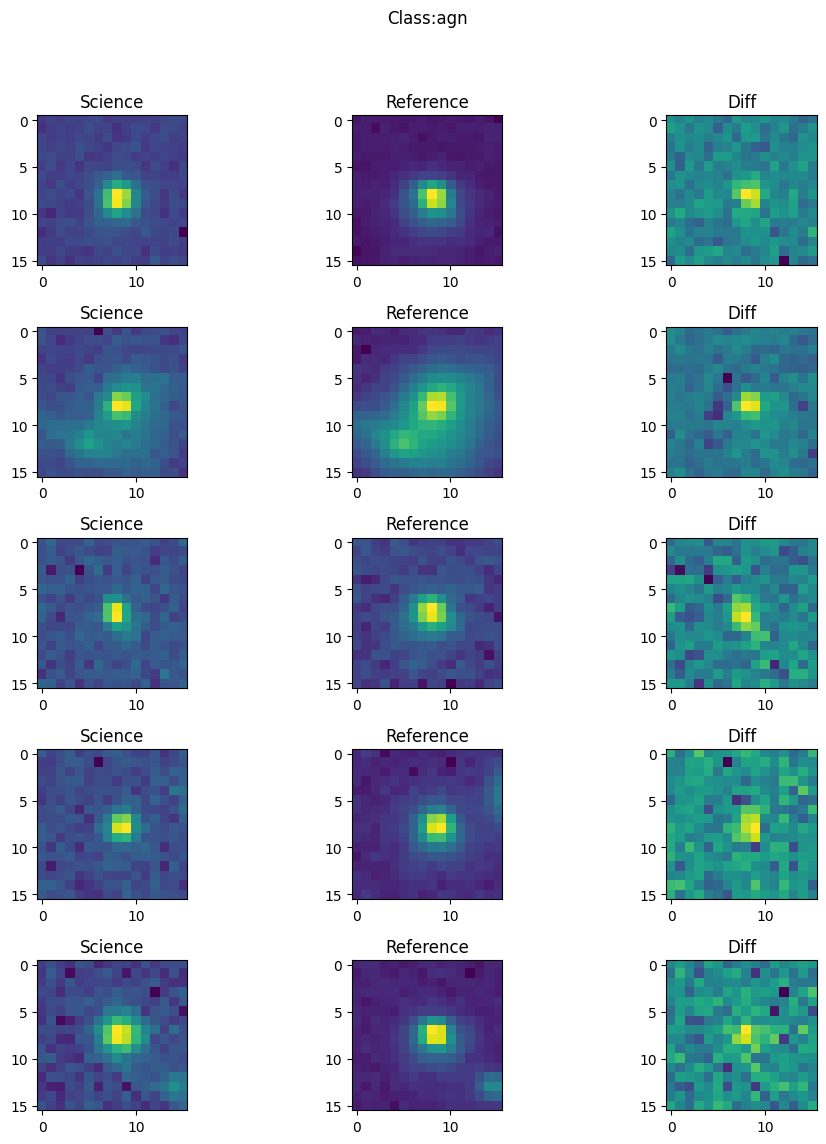

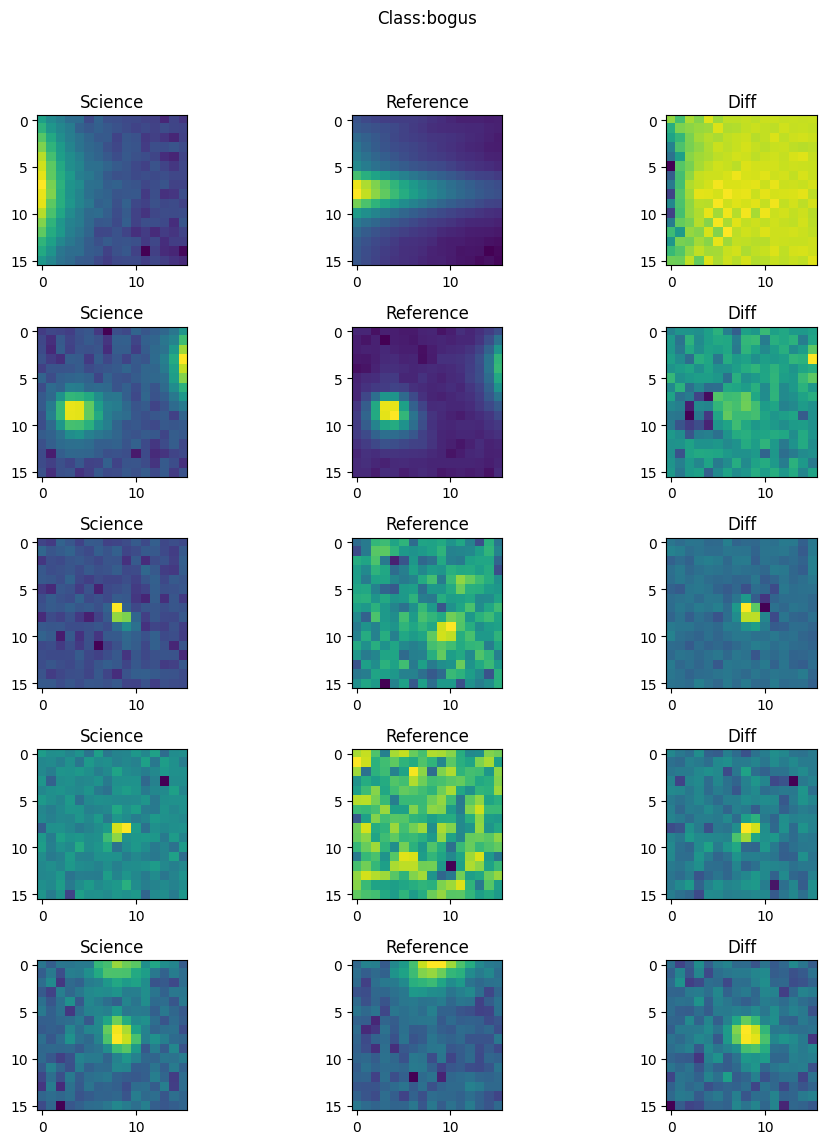

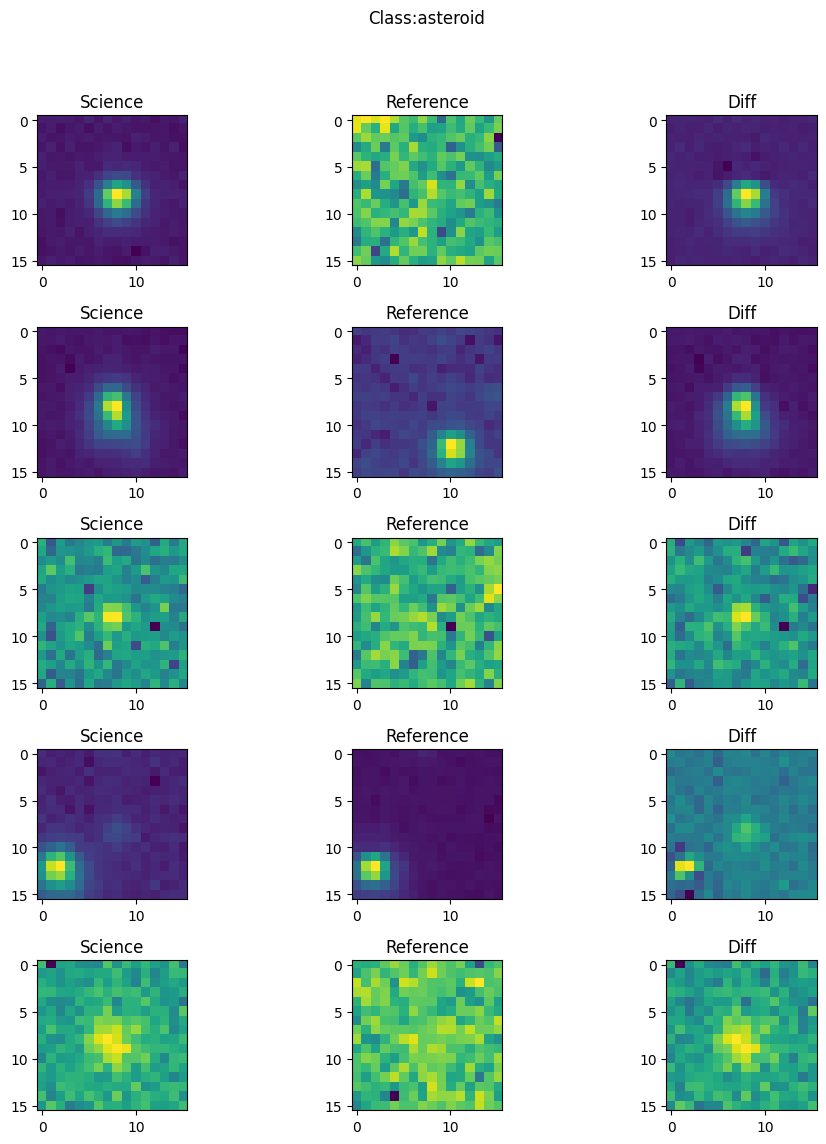

In [172]:
#Visualizamos 5 objetos aleatorios por cada clase pero ahora para los recortes
for cls in df_label['class'].unique():
    sample=df_label[df_label['class']==cls].sample(5,random_state=68884)

    fig, ax =plt.subplots(5,3,figsize=(10,12))
    fig.suptitle(f'Class:{cls}')
    for i , (_,r) in enumerate(sample.iterrows()):
        img_sc=preprocess(r['science'])
        norm_sc=ImageNormalize(img_sc,interval=MinMaxInterval(),stretch=SqrtStretch())
        ax[i,0].imshow(img_sc,norm=norm_sc,cmap='viridis')
        ax[i,0].set_title('Science')


        img_ref=preprocess(r['reference'])
        norm_ref=ImageNormalize(img_ref,interval=MinMaxInterval(),stretch=SqrtStretch())
        ax[i,1].imshow(img_ref,norm=norm_ref,cmap='viridis')
        ax[i,1].set_title('Reference')


        img_diff=preprocess(r['diff'])
        norm_diff=ImageNormalize(img_diff,interval=MinMaxInterval(),stretch=SqrtStretch())
        ax[i,2].imshow(img_diff,norm=norm_diff,cmap='viridis')
        ax[i,2].set_title('Diff')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [173]:
# Convertimos las etiquetas de clase a códigos numéricos
df['class_encoded'] = df['class'].astype('category').cat.codes

# Convertimos las imágenes a tensores de PyTorch
X = torch.from_numpy(np.stack(df['processed_img'].values)).float()
y = torch.from_numpy(df['class_encoded'].values).long()

#Dividimos los datos en train y test estratificando por clase
x_train, x_test, y_train, y_test = train_test_split( X , y , test_size=0.3,stratify=y,random_state=8742)



In [174]:
print("\n--- Verificando rango y valores NaN/Inf  ---")
print(f"Min value in X : {X.min().item()}")
print(f"Max value in X : {X.max().item()}")
print(f"Contains NaN : {torch.isnan(X).any().item()}")
print(f"Contains Inf : {torch.isinf(X).any().item()}")


--- Verificando rango y valores NaN/Inf  ---
Min value in X : 0.0
Max value in X : 1.0
Contains NaN : False
Contains Inf : False


In [175]:
#Dividimos el train set en train y validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


for fold, (train_idx, val_idx) in enumerate(skf.split(x_train, y_train)):
    
    x_val, y_val = x_train[val_idx], y_train[val_idx]
    x_train, y_train = x_train[train_idx], y_train[train_idx]
    
    
   
    break #usamos solo el primer fold como validation
print(f'Train size: {len(x_train)} , Validation size: {len(x_val)}, Test size: {len(x_test)}')




Train size: 28192 , Validation size: 7049, Test size: 15104


In [176]:
#preparamos los datos para el modelo
train_dataset=TensorDataset(x_train,y_train)
val_dataset=TensorDataset(x_val,y_val)
test_dataset=TensorDataset(x_test,y_test)

batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [177]:
# --- Modelo VAE  ---
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim=latent_dim
        
        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),   #(3,16,16)  ->  (32,8,8)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  #(32,8,8)  ->  (64,4,4)
            nn.ReLU(),
            nn.Flatten()      #(64,4,4)  ->  (1024)
        )
        
        #Latent space
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        #Decoder
        self.decoder_input = nn.Linear(latent_dim, 1024)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 4, 4)),   # (1024) -> (64,4,4)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), #(64,4,4)  -> (32,8,8) 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  #(32,8,8)  ->  (3,16,16) 
            nn.Sigmoid()
        )
    def encode(self,x):
        h=self.encoder(x)
        mu=self.fc_mu(h)
        logvar=self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        recon_x = self.decoder(h)
        return recon_x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# --- Loss fn ---
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [178]:
#configuramos el modelo
model=VAE().to(device)
optimizer=optim.Adam(model.parameters(), lr=1e-3)

In [179]:
#train fn
def train_epoch(model,dataloader,optim,device):
    model.train()
    train_loss=0
    for data , _ in dataloader:
        data=data.to(device)
        optim.zero_grad()
        recon, mu, logvar=model(data)
        loss=loss_function(recon,data,mu,logvar)
        loss.backward()
        train_loss+= loss.item()
        optim.step()
    return train_loss/len(dataloader.dataset)

#val fn
def val_epoch(model,dataloader,device):
    model.eval()
    val_loss=0
    with torch.no_grad():
        for data, _ in dataloader:
            data=data.to(device)
            recon , mu , logvar=model(data)
            loss=loss_function(recon,data,mu,logvar)
            val_loss+=loss.item()
    return val_loss/len(dataloader.dataset)




In [180]:
#entrenamos el modelo
epochs=30
train_losses=[]
val_losses=[]
for epoch in range(epochs):
    train_loss=train_epoch(model,train_loader,optimizer,device)
    val_loss=val_epoch(model,val_loader,device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch: {epoch+1}/{epochs}- Train Loss: {train_loss:.3f} - Val Loss: {val_loss:.3f}')


Epoch: 1/30- Train Loss: 363.875 - Val Loss: 327.830
Epoch: 2/30- Train Loss: 323.241 - Val Loss: 318.142
Epoch: 3/30- Train Loss: 317.807 - Val Loss: 315.940
Epoch: 4/30- Train Loss: 316.511 - Val Loss: 315.142
Epoch: 5/30- Train Loss: 315.936 - Val Loss: 314.738
Epoch: 6/30- Train Loss: 315.486 - Val Loss: 314.397
Epoch: 7/30- Train Loss: 315.179 - Val Loss: 314.181
Epoch: 8/30- Train Loss: 314.945 - Val Loss: 313.896
Epoch: 9/30- Train Loss: 314.756 - Val Loss: 313.621
Epoch: 10/30- Train Loss: 314.560 - Val Loss: 313.775
Epoch: 11/30- Train Loss: 314.470 - Val Loss: 313.468
Epoch: 12/30- Train Loss: 314.354 - Val Loss: 313.599
Epoch: 13/30- Train Loss: 314.320 - Val Loss: 313.295
Epoch: 14/30- Train Loss: 314.190 - Val Loss: 313.270
Epoch: 15/30- Train Loss: 314.145 - Val Loss: 313.206
Epoch: 16/30- Train Loss: 314.088 - Val Loss: 313.108
Epoch: 17/30- Train Loss: 314.031 - Val Loss: 313.001
Epoch: 18/30- Train Loss: 313.984 - Val Loss: 313.039
Epoch: 19/30- Train Loss: 313.933 - V

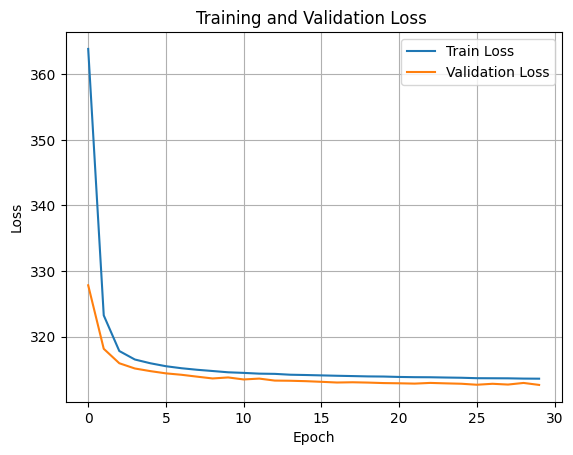

In [181]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()
plt.grid()
plt.show()

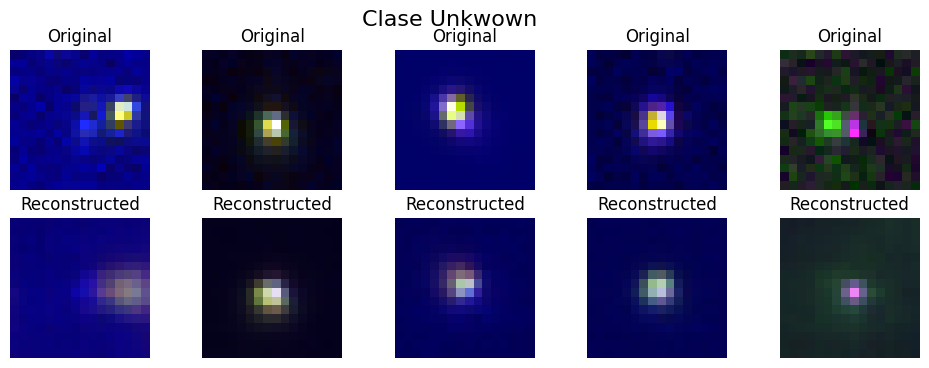

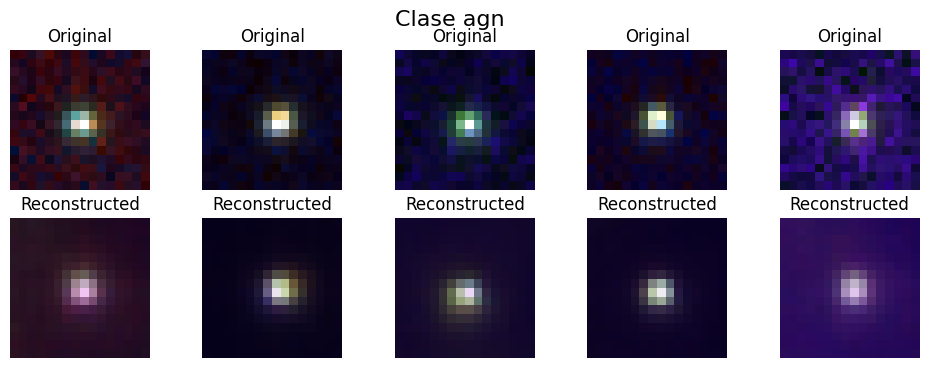

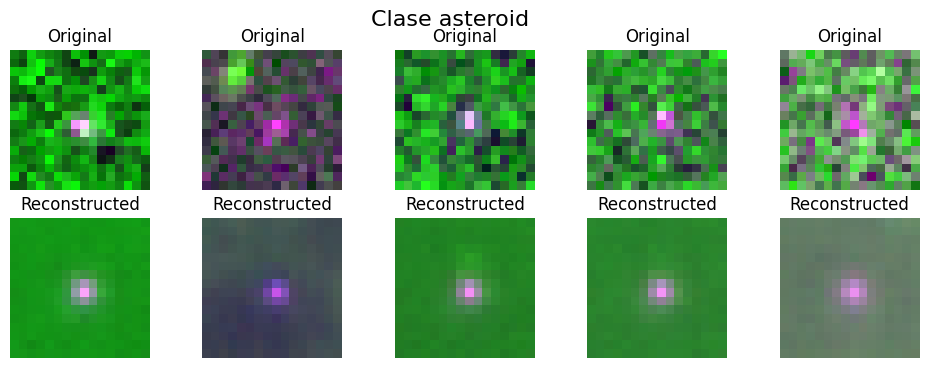

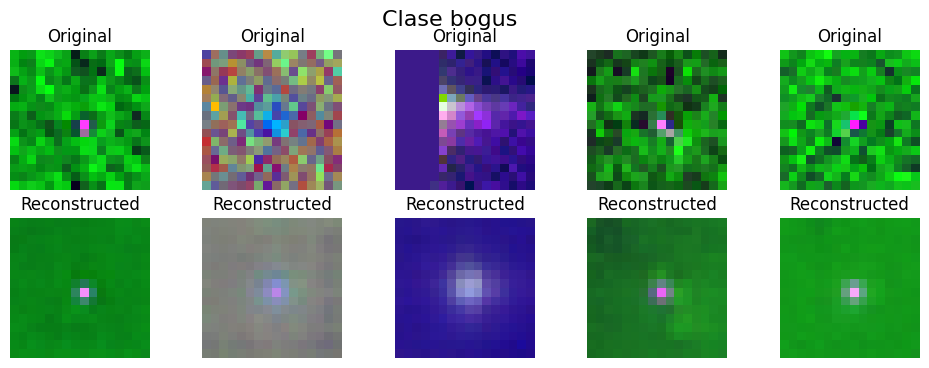

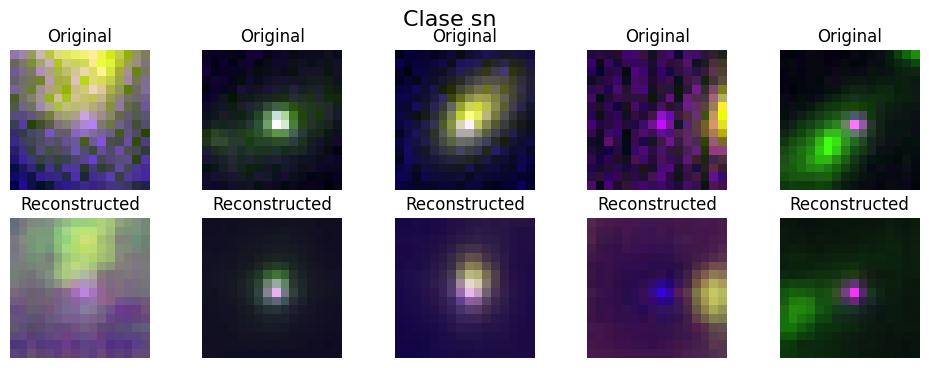

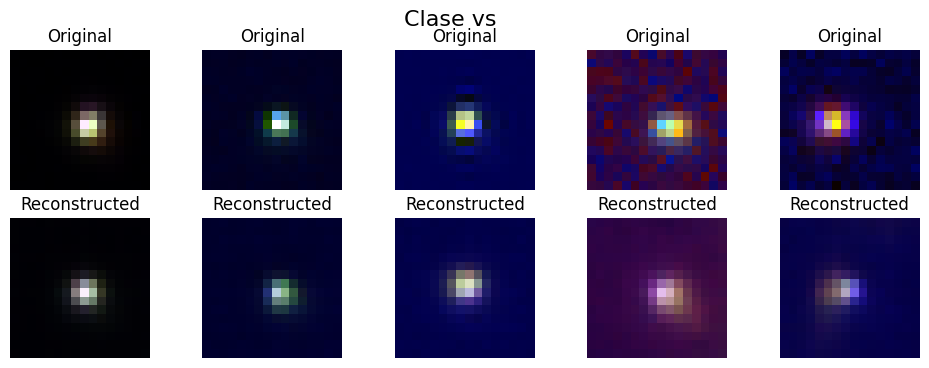

In [182]:
#visualizamos 5 reconstrucciones por clase para los datos de testeo
labels=df['class'].astype('category').cat.categories
random.seed(4888)
model.eval()
x_test = x_test.to(device)
y_test = y_test.to(device)


clases = torch.unique(y_test)


for clase in clases:
    
    indices = torch.where(y_test == clase)[0]

    
    seleccionados = random.sample(indices.tolist(), 5)

    
    imagenes = x_test[seleccionados]

    
    with torch.no_grad():
        recon, _, _ = model(imagenes)

    
    fig, axs = plt.subplots(2, 5, figsize=(12, 4))
    fig.suptitle(f'Clase {labels[clase.item()]}', fontsize=16)

    for i in range(5):
        # Original
        norm=ImageNormalize(imagenes[i].cpu().permute(1, 2, 0),MinMaxInterval(),stretch=SqrtStretch())
        axs[0, i].imshow(imagenes[i].cpu().permute(1, 2, 0),norm=norm)
        axs[0, i].axis('off')
        axs[0, i].set_title('Original')   
        # Reconstrucción
        axs[1, i].imshow(recon[i].cpu().permute(1, 2, 0),norm=norm)
        axs[1, i].axis('off')
        axs[1, i].set_title('Reconstructed')



    
    plt.show()


El modelo reconstruye bien las imagenes nuevas. Notar que estamos usando las 3 imagenes como canales RGB pero no hay problema dado que solo interesa ver que tan bien reconstruye la imagen original

In [183]:
model.eval()

#funcion para obtener el espacio latente
def get_latentspace(model,dataloader,device):
    latentspace=[]
    labels=[]
    with torch.no_grad():
        for data, label in dataloader:
            data=data.to(device)
            mu, logvar = model.encode(data)
            z=model.reparameterize(mu, logvar)
            latentspace.extend(z.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return np.array(latentspace), np.array(labels)

latent_data, labels_data= get_latentspace(model,test_loader,device)

#UMAP
reducer=UMAP(n_components=2,random_state=88596)
embeding=reducer.fit_transform(latent_data)


c:\Users\Luciano\Desktop\ASTROINFO\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Luciano\Desktop\ASTROINFO\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0, 0.5, 'UMAP Componente 2')

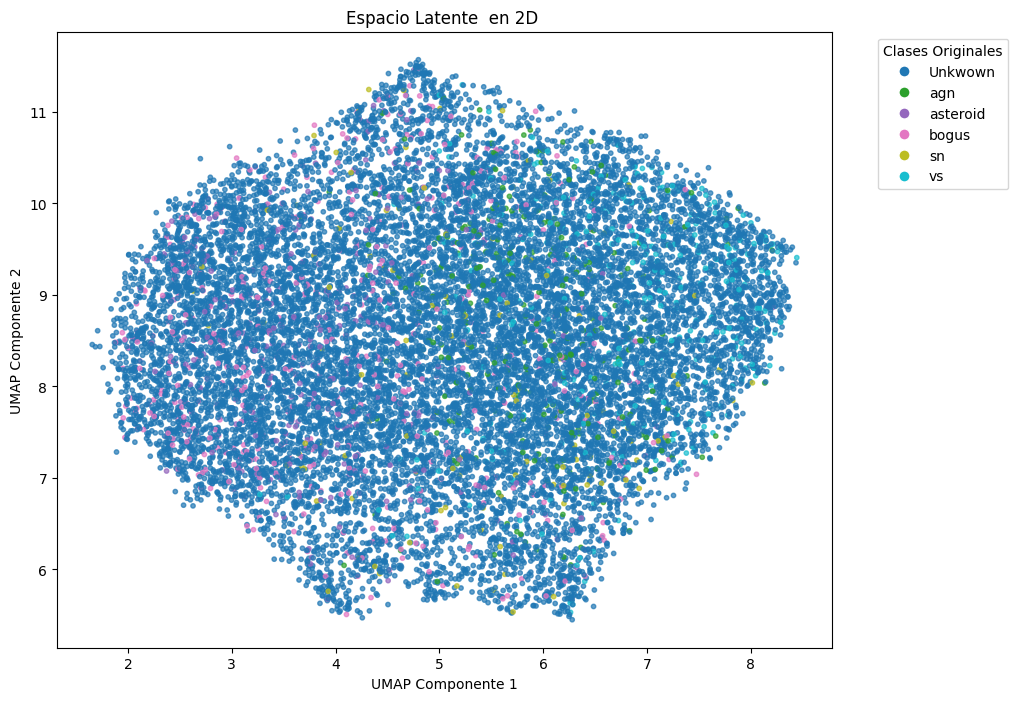

In [184]:
#Visualizar el espacio latente
plt.figure(figsize=(10, 8))

scatter = plt.scatter(embeding[:, 0], embeding[:, 1], c=labels_data, cmap='tab10', s=10, alpha=0.7)


labels_unique = np.unique(labels_data)
handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=scatter.cmap(scatter.norm(l)), 
                          markersize=8) for l in labels_unique]
plt.legend(handles=handles, labels=[labels[i] for i in labels_unique],
               title='Clases Originales', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Espacio Latente  en 2D ')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')

Vemos que las clases no se agrupan

In [185]:
# --- Modelo VAE semisupervisado  ---
class SS_VAE(nn.Module):
    def __init__(self, latent_dim=20,n_cls=None):
        super(SS_VAE, self).__init__()
        self.latent_dim=latent_dim
        self.n_cls=n_cls
        #Encoder (igual)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),   #(3,16,16)  ->  (32,8,8)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  #(32,8,8)  ->  (64,4,4)
            nn.ReLU(),
            nn.Flatten()      #(64,4,4)  ->  (1024)
        )
        
        #Latent space (igual)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        #Decoder    (igual)
        self.decoder_input = nn.Linear(latent_dim, 1024)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 4, 4)),   # (1024) -> (64,4,4)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), #(64,4,4)  -> (32,8,8) 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  #(32,8,8)  ->  (3,16,16) 
            nn.Sigmoid()
        )

        #Clasificador
        if self.n_cls is not None and self.n_cls>0:
            self.classifier=nn.Sequential(
                nn.Linear(latent_dim,128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128,self.n_cls)
            )
        else:
            self.classifier=None

    def encode(self,x):
        h=self.encoder(x)
        mu=self.fc_mu(h)
        logvar=self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        recon_x = self.decoder(h)
        return recon_x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        if self.classifier is not None:
            cls=self.classifier(z)
            return recon_x,mu,logvar,cls
        else:
            return recon_x, mu, logvar

# --- Loss fn con penalizacion por clase---
def loss_function_ss(recon_x, x, mu, logvar,cls=None, lbs_batch=None,lambda_cls=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    cls_loss = torch.tensor(0.0, device=x.device)
    if cls is not None and lbs_batch is not None:
        lb_mask=(lbs_batch!=0)
        if lb_mask.sum()>0:
            filt_cls=cls[lb_mask]
            #remapeamos las cls para aplicar cross entropy
            rmp_lbs=(lbs_batch[lb_mask]-1).long()
            cls_loss=F.cross_entropy(filt_cls,rmp_lbs,reduction='sum')
    return BCE + KLD +lambda_cls*cls_loss, BCE + KLD, cls_loss


In [186]:
#configuramos el modelo
model_ss=SS_VAE(n_cls=5).to(device)
optimizer_ss=optim.Adam(model_ss.parameters(), lr=1e-3)

In [187]:
#train fn semisupervised
def train_epoch_ss(model,dataloader,optim,device):
    model.train()
    train_loss=0
    train_vae_loss=0
    train_clf_loss=0
    for data , lbs_batch in dataloader:
        data=data.to(device)
        lbs_batch=lbs_batch.to(device)
        optim.zero_grad()
        recon, mu, logvar, cls=model(data)
        total_loss,vae_loss,clf_loss=loss_function_ss(recon,data,mu,logvar,cls=cls,lbs_batch=lbs_batch)
        total_loss.backward()
        train_loss+= total_loss.cpu().item()
        train_vae_loss+= vae_loss.cpu().item()
        train_clf_loss+= clf_loss.cpu().item()
        optim.step()
    return train_loss/len(dataloader.dataset), train_vae_loss/len(dataloader.dataset), train_clf_loss/len(dataloader.dataset)

#val fn semisupervised
def val_epoch_ss(model,dataloader,device):
    model.eval()
    val_loss=0
    val_vae_loss=0
    val_clf_loss=0
    with torch.no_grad():
        for data, lbs_batch in dataloader:
            data=data.to(device)
            lbs_batch=lbs_batch.to(device)
            recon , mu , logvar, cls=model(data)
            total_loss,vae_loss,clf_loss=loss_function_ss(recon,data,mu,logvar,cls=cls,lbs_batch=lbs_batch)
            val_loss+=total_loss.cpu().item()
            val_vae_loss+=vae_loss.cpu().item()
            val_clf_loss+=clf_loss.cpu().item()
    return val_loss/len(dataloader.dataset), val_vae_loss/len(dataloader.dataset), val_clf_loss/len(dataloader.dataset)


In [188]:
#entrenamos el modelo
epochs=30
train_losses_ss=[]
train_vae_losses_ss=[]
train_clf_losses_ss=[]
val_losses_ss=[]
val_vae_losses_ss=[]
val_clf_losses_ss=[]
for epoch in range(epochs):
    train_loss,train_vae_loss,train_clf_loss=train_epoch_ss(model_ss,train_loader,optimizer_ss,device)
    val_loss,val_vae_loss,val_clf_loss=val_epoch_ss(model_ss,val_loader,device)
    train_losses_ss.append(train_loss)
    val_losses_ss.append(val_loss)
    train_vae_losses_ss.append(train_vae_loss)
    val_vae_losses_ss.append(val_vae_loss)
    train_clf_losses_ss.append(train_clf_loss)
    val_clf_losses_ss.append(val_clf_loss)

    print(f'Epoch: {epoch+1}/{epochs} - '
          f'Train Total Loss: {train_loss:.3f} (VAE: {train_vae_loss:.3f}, CLF: {train_clf_loss:.3f}) - '
          f'Val Total Loss: {val_loss:.3f} (VAE: {val_vae_loss:.3f}, CLF: {val_clf_loss:.3f})')


Epoch: 1/30 - Train Total Loss: 365.065 (VAE: 364.927, CLF: 0.138) - Val Total Loss: 327.952 (VAE: 327.832, CLF: 0.119)
Epoch: 2/30 - Train Total Loss: 324.728 (VAE: 324.614, CLF: 0.114) - Val Total Loss: 319.791 (VAE: 319.678, CLF: 0.113)
Epoch: 3/30 - Train Total Loss: 318.794 (VAE: 318.686, CLF: 0.108) - Val Total Loss: 316.151 (VAE: 316.044, CLF: 0.107)
Epoch: 4/30 - Train Total Loss: 316.726 (VAE: 316.623, CLF: 0.103) - Val Total Loss: 315.493 (VAE: 315.392, CLF: 0.101)
Epoch: 5/30 - Train Total Loss: 316.182 (VAE: 316.084, CLF: 0.098) - Val Total Loss: 314.934 (VAE: 314.836, CLF: 0.099)
Epoch: 6/30 - Train Total Loss: 315.811 (VAE: 315.716, CLF: 0.095) - Val Total Loss: 314.635 (VAE: 314.538, CLF: 0.097)
Epoch: 7/30 - Train Total Loss: 315.431 (VAE: 315.339, CLF: 0.092) - Val Total Loss: 314.401 (VAE: 314.306, CLF: 0.095)
Epoch: 8/30 - Train Total Loss: 315.169 (VAE: 315.078, CLF: 0.090) - Val Total Loss: 314.307 (VAE: 314.213, CLF: 0.093)
Epoch: 9/30 - Train Total Loss: 314.950 

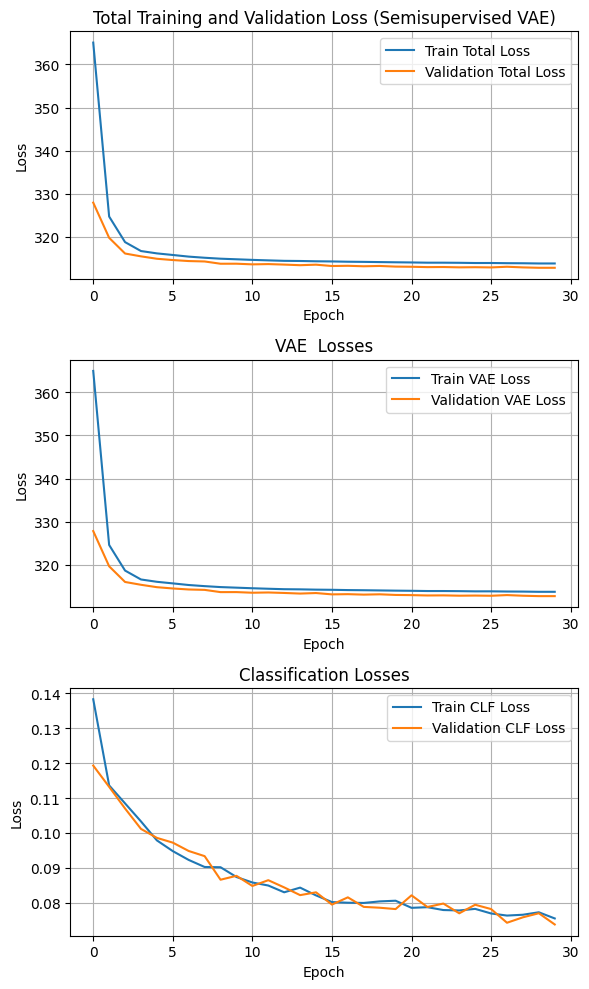

In [189]:
# --- Visualización de Pérdidas del VAE Semisupervisado ---

plt.figure(figsize=(6,10))


plt.subplot(3, 1, 1) 
plt.plot(train_losses_ss, label='Train Total Loss') 
plt.plot(val_losses_ss, label='Validation Total Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Training and Validation Loss (Semisupervised VAE)')
plt.legend()
plt.grid()


plt.subplot(3, 1, 2) 
plt.plot(train_vae_losses_ss, label='Train VAE Loss') 
plt.plot(val_vae_losses_ss, label='Validation VAE Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE  Losses') 
plt.legend()
plt.grid()


plt.subplot(3, 1, 3) 
plt.plot(train_clf_losses_ss, label='Train CLF Loss') 
plt.plot(val_clf_losses_ss, label='Validation CLF Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Losses')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

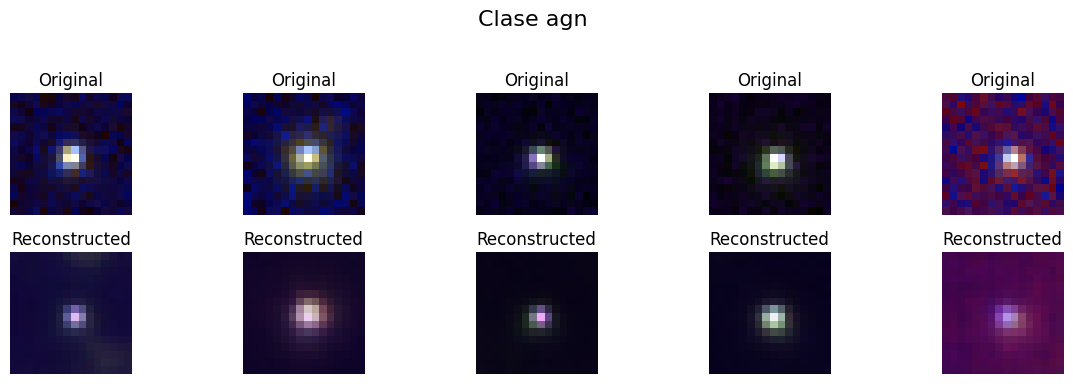

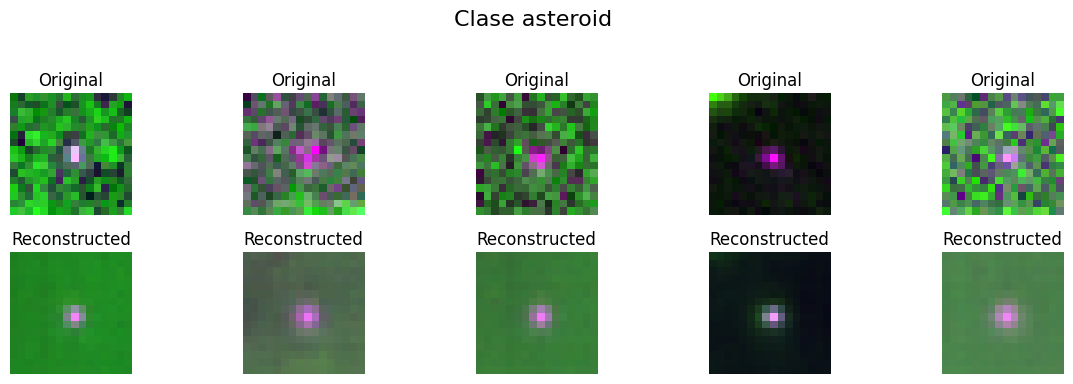

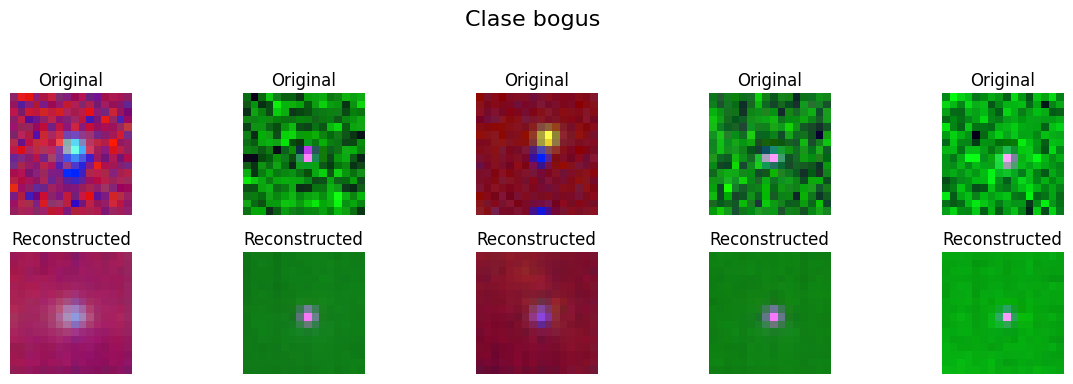

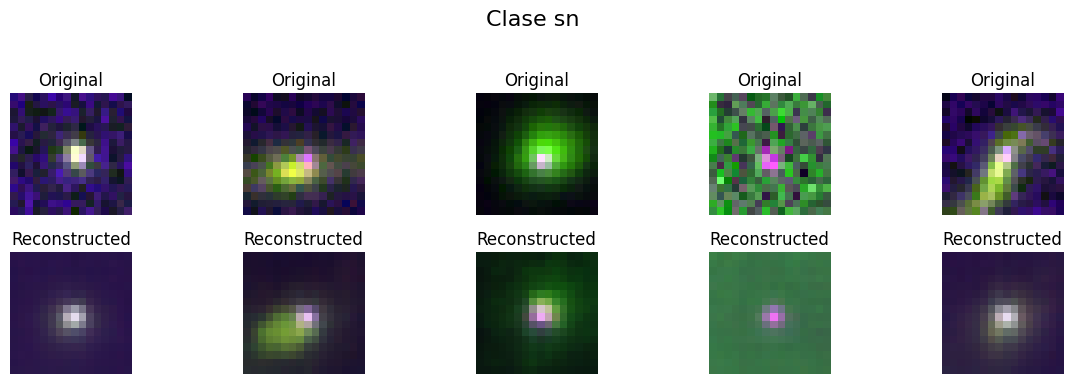

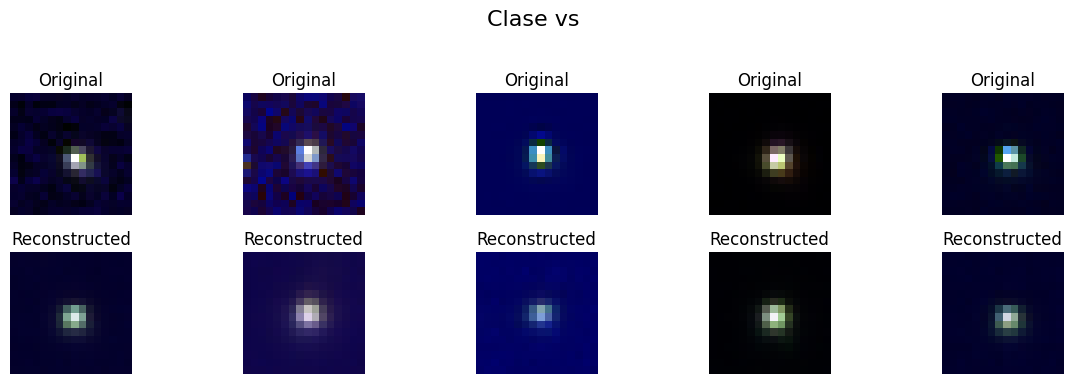

In [190]:

# ---  VISUALIZACIONES PARA EL VAE SEMISUPERVISADO  ---



model_ss.eval()

random.seed(4888)

for clase_code in torch.unique(y_test):
    if clase_code.item() == 0:
        continue

    indices = torch.where(y_test == clase_code)[0]

    
    seleccionados = random.sample(indices.tolist(), 5)

    

    imagenes = x_test[seleccionados]

    with torch.no_grad():
        recon, _, _, _ = model_ss(imagenes)

    num_imagenes_a_mostrar = len(seleccionados)
    fig, axs = plt.subplots(2, num_imagenes_a_mostrar, figsize=(2.4 * num_imagenes_a_mostrar, 4))
    fig.suptitle(f'Clase {labels[clase_code.item()]} ', fontsize=16)

    for i in range(num_imagenes_a_mostrar):
        img_original_np = imagenes[i].cpu().permute(1, 2, 0).numpy()
        norm_orig = ImageNormalize(img_original_np, interval=MinMaxInterval(), stretch=SqrtStretch())
        if num_imagenes_a_mostrar == 1:
            axs[0].imshow(img_original_np, norm=norm_orig)
            axs[0].axis('off')
            axs[0].set_title('Original')
        else:
            axs[0, i].imshow(img_original_np, norm=norm_orig)
            axs[0, i].axis('off')
            axs[0, i].set_title('Original')

        img_recon_np = recon[i].cpu().permute(1, 2, 0).numpy()
        norm_recon = ImageNormalize(img_recon_np, interval=MinMaxInterval(), stretch=SqrtStretch())
        if num_imagenes_a_mostrar == 1:
            axs[1].imshow(img_recon_np, norm=norm_recon)
            axs[1].axis('off')
            axs[1].set_title('Reconstructed')
        else:
            axs[1, i].imshow(img_recon_np, norm=norm_recon)
            axs[1, i].axis('off')
            axs[1, i].set_title('Reconstructed')

    if num_imagenes_a_mostrar == 1:
        axs[0].set_ylabel("Original", fontsize=12)
        axs[1].set_ylabel("Reconstruido", fontsize=12)
    else:
        axs[0, 0].set_ylabel("Original", fontsize=12)
        axs[1, 0].set_ylabel("Reconstruido", fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



Accuracy en las clases conocidas: 0.7086

Reporte de Clasificación:
              precision    recall  f1-score   support

         agn       0.65      0.75      0.70       291
    asteroid       0.69      0.63      0.66       283
       bogus       0.71      0.78      0.74       497
          sn       0.58      0.30      0.40       116
          vs       0.80      0.78      0.79       323

    accuracy                           0.71      1510
   macro avg       0.69      0.65      0.66      1510
weighted avg       0.71      0.71      0.70      1510


Matriz de Confusión:


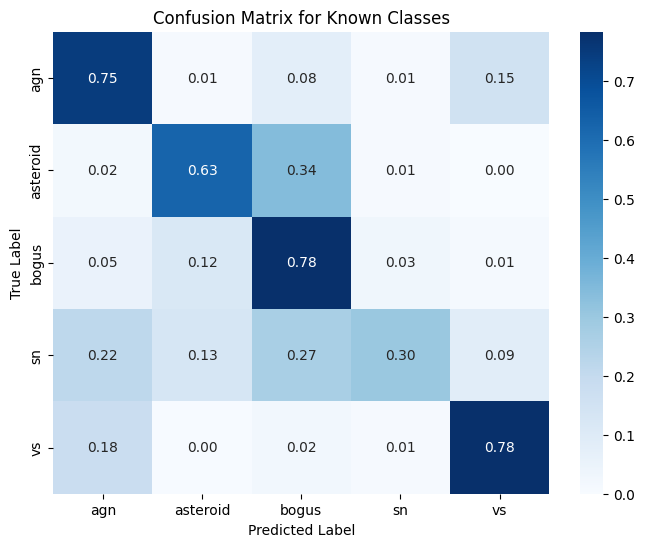

In [191]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns 

# --- Evaluación del clasificador ---


model_ss.eval() 
all_predicted_labels = []
all_true_labels_remapped = []

with torch.no_grad(): 
    for data, labels_batch in test_loader:
        data = data.to(device)
        labels_batch = labels_batch.to(device)

        
        _, _, _, cls = model_ss(data)

        
        labeled_mask = (labels_batch != 0)

        if labeled_mask.sum() > 0: 
            filtered_logits = cls[labeled_mask]
            true_labels_batch = labels_batch[labeled_mask]

            
            remapped_true_labels = (true_labels_batch - 1).long()

            
            predicted_labels = torch.argmax(filtered_logits, dim=1)

            
            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_true_labels_remapped.extend(remapped_true_labels.cpu().numpy())


all_predicted_labels = np.array(all_predicted_labels)
all_true_labels_remapped = np.array(all_true_labels_remapped)


classifier_class_names = [labels[i] for i in range(1, len(labels))]

print(f"\nAccuracy en las clases conocidas: {accuracy_score(all_true_labels_remapped, all_predicted_labels):.4f}")

print("\nReporte de Clasificación:")
print(classification_report(all_true_labels_remapped, all_predicted_labels, target_names=classifier_class_names, zero_division=0))

print("\nMatriz de Confusión:")
cm = confusion_matrix(all_true_labels_remapped, all_predicted_labels,normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classifier_class_names, yticklabels=classifier_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Known Classes')
plt.show()



Vemos que las reconstrucciones las realiza bien pero la clasificacion no , tal como se aprecia en la matriz. Aumentemos ahora el peso de el loss de la clasificacion para ver si obtenemos mejores resultados

In [192]:
model_ss=SS_VAE(n_cls=5).to(device)
optimizer_ss=optim.Adam(model_ss.parameters(), lr=1e-3)
#train fn semisupervised
def train_epoch_ss(model,dataloader,optim,device):
    model.train()
    train_loss=0
    train_vae_loss=0
    train_clf_loss=0
    for data , lbs_batch in dataloader:
        data=data.to(device)
        lbs_batch=lbs_batch.to(device)
        optim.zero_grad()
        recon, mu, logvar, cls=model(data)
        total_loss,vae_loss,clf_loss=loss_function_ss(recon,data,mu,logvar,cls=cls,lbs_batch=lbs_batch,lambda_cls=100) #aumentamos el peso
        total_loss.backward()
        train_loss+= total_loss.cpu().item()
        train_vae_loss+= vae_loss.cpu().item()
        train_clf_loss+= clf_loss.cpu().item()
        optim.step()
    return train_loss/len(dataloader.dataset), train_vae_loss/len(dataloader.dataset), train_clf_loss/len(dataloader.dataset)

#val fn semisupervised
def val_epoch_ss(model,dataloader,device):
    model.eval()
    val_loss=0
    val_vae_loss=0
    val_clf_loss=0
    with torch.no_grad():
        for data, lbs_batch in dataloader:
            data=data.to(device)
            lbs_batch=lbs_batch.to(device)
            recon , mu , logvar, cls=model(data)
            total_loss,vae_loss,clf_loss=loss_function_ss(recon,data,mu,logvar,cls=cls,lbs_batch=lbs_batch,lambda_cls=100) #aumentamos el peso
            val_loss+=total_loss.cpu().item()
            val_vae_loss+=vae_loss.cpu().item()
            val_clf_loss+=clf_loss.cpu().item()
    return val_loss/len(dataloader.dataset), val_vae_loss/len(dataloader.dataset), val_clf_loss/len(dataloader.dataset)

#entrenamos el modelo
epochs=30
train_losses_ss=[]
train_vae_losses_ss=[]
train_clf_losses_ss=[]
val_losses_ss=[]
val_vae_losses_ss=[]
val_clf_losses_ss=[]
for epoch in range(epochs):
    train_loss,train_vae_loss,train_clf_loss=train_epoch_ss(model_ss,train_loader,optimizer_ss,device)
    val_loss,val_vae_loss,val_clf_loss=val_epoch_ss(model_ss,val_loader,device)
    train_losses_ss.append(train_loss)
    val_losses_ss.append(val_loss)
    train_vae_losses_ss.append(train_vae_loss)
    val_vae_losses_ss.append(val_vae_loss)
    train_clf_losses_ss.append(train_clf_loss)
    val_clf_losses_ss.append(val_clf_loss)

    print(f'Epoch: {epoch+1}/{epochs} - '
          f'Train Total Loss: {train_loss:.3f} (VAE: {train_vae_loss:.3f}, CLF: {train_clf_loss:.3f}) - '
          f'Val Total Loss: {val_loss:.3f} (VAE: {val_vae_loss:.3f}, CLF: {val_clf_loss:.3f})')


Epoch: 1/30 - Train Total Loss: 373.290 (VAE: 360.062, CLF: 0.132) - Val Total Loss: 338.233 (VAE: 327.033, CLF: 0.112)
Epoch: 2/30 - Train Total Loss: 334.908 (VAE: 324.586, CLF: 0.103) - Val Total Loss: 331.391 (VAE: 321.331, CLF: 0.101)
Epoch: 3/30 - Train Total Loss: 329.380 (VAE: 320.025, CLF: 0.094) - Val Total Loss: 326.802 (VAE: 317.287, CLF: 0.095)
Epoch: 4/30 - Train Total Loss: 326.324 (VAE: 318.001, CLF: 0.083) - Val Total Loss: 324.614 (VAE: 316.394, CLF: 0.082)
Epoch: 5/30 - Train Total Loss: 325.039 (VAE: 317.340, CLF: 0.077) - Val Total Loss: 324.033 (VAE: 316.065, CLF: 0.080)
Epoch: 6/30 - Train Total Loss: 324.039 (VAE: 316.906, CLF: 0.071) - Val Total Loss: 323.019 (VAE: 315.922, CLF: 0.071)
Epoch: 7/30 - Train Total Loss: 323.254 (VAE: 316.576, CLF: 0.067) - Val Total Loss: 322.601 (VAE: 315.354, CLF: 0.072)
Epoch: 8/30 - Train Total Loss: 322.820 (VAE: 316.290, CLF: 0.065) - Val Total Loss: 322.366 (VAE: 315.187, CLF: 0.072)
Epoch: 9/30 - Train Total Loss: 322.274 

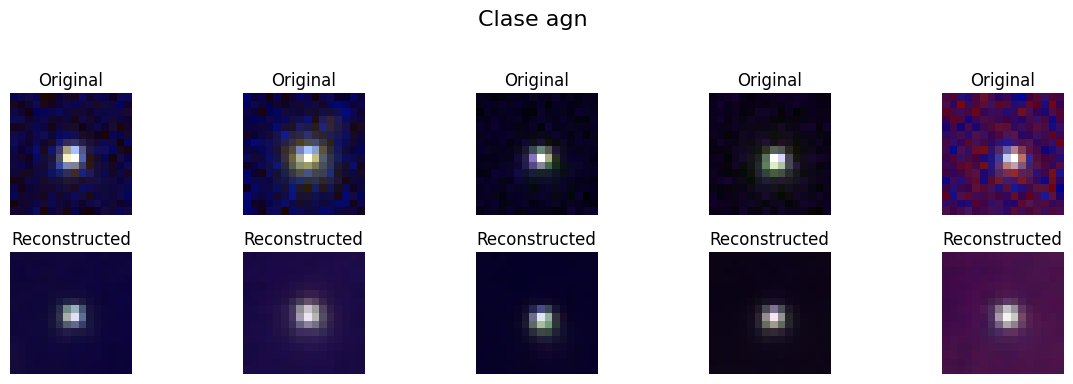

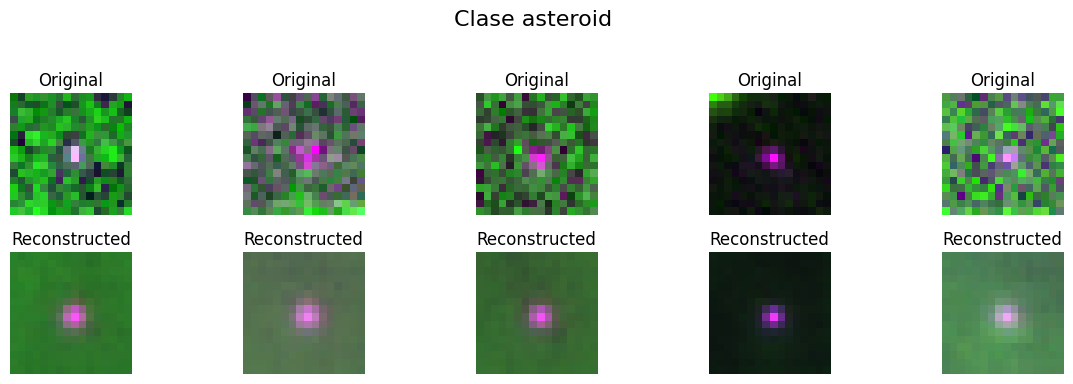

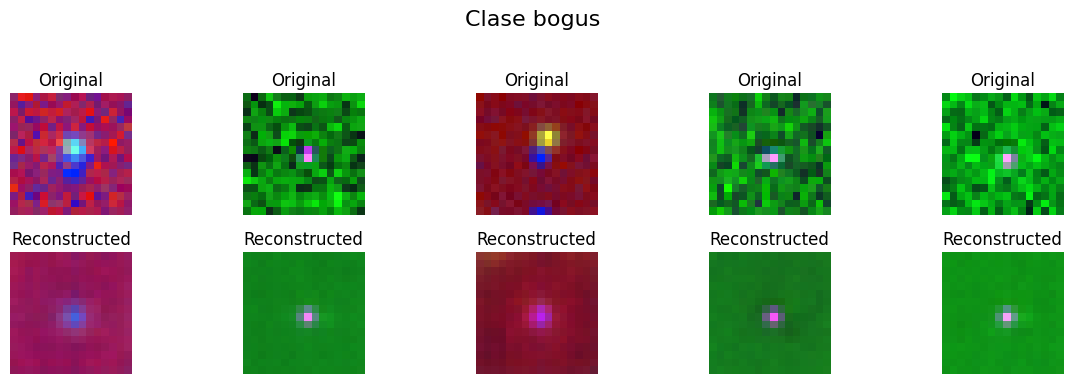

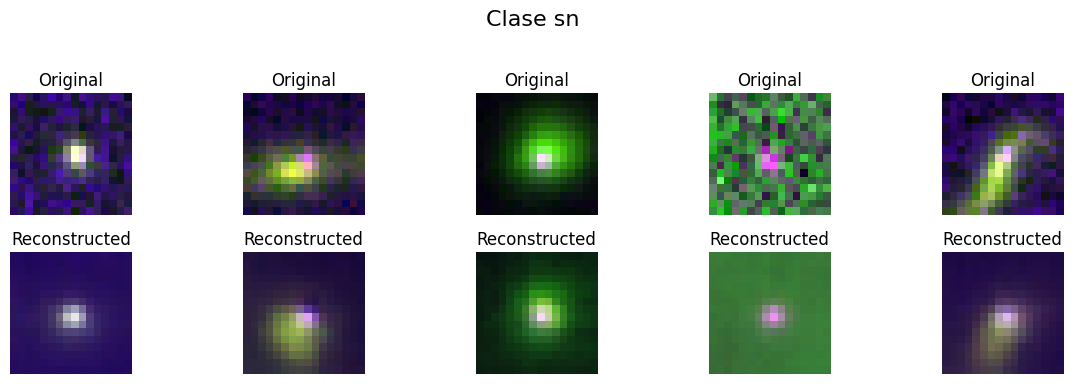

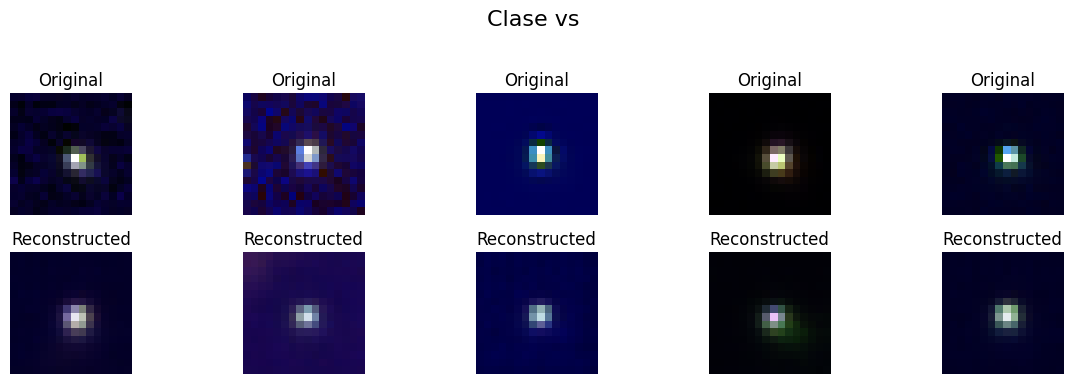


Accuracy en las clases conocidas: 0.7841

Reporte de Clasificación:
              precision    recall  f1-score   support

         agn       0.78      0.74      0.76       291
    asteroid       0.82      0.78      0.80       283
       bogus       0.82      0.85      0.83       497
          sn       0.49      0.49      0.49       116
          vs       0.82      0.82      0.82       323

    accuracy                           0.78      1510
   macro avg       0.74      0.74      0.74      1510
weighted avg       0.78      0.78      0.78      1510


Matriz de Confusión:


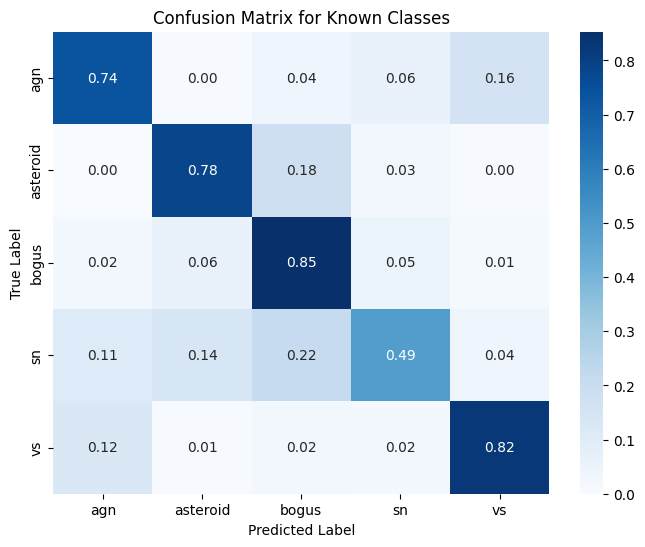

In [193]:

# ---  VISUALIZACIONES PARA EL VAE SEMISUPERVISADO  ---



model_ss.eval()

random.seed(4888)

for clase_code in torch.unique(y_test):
    if clase_code.item() == 0:
        continue

    indices = torch.where(y_test == clase_code)[0]

    
    seleccionados = random.sample(indices.tolist(), 5)

    

    imagenes = x_test[seleccionados]

    with torch.no_grad():
        recon, _, _, _ = model_ss(imagenes)

    num_imagenes_a_mostrar = len(seleccionados)
    fig, axs = plt.subplots(2, num_imagenes_a_mostrar, figsize=(2.4 * num_imagenes_a_mostrar, 4))
    fig.suptitle(f'Clase {labels[clase_code.item()]} ', fontsize=16)

    for i in range(num_imagenes_a_mostrar):
        img_original_np = imagenes[i].cpu().permute(1, 2, 0).numpy()
        norm_orig = ImageNormalize(img_original_np, interval=MinMaxInterval(), stretch=SqrtStretch())
        if num_imagenes_a_mostrar == 1:
            axs[0].imshow(img_original_np, norm=norm_orig)
            axs[0].axis('off')
            axs[0].set_title('Original')
        else:
            axs[0, i].imshow(img_original_np, norm=norm_orig)
            axs[0, i].axis('off')
            axs[0, i].set_title('Original')

        img_recon_np = recon[i].cpu().permute(1, 2, 0).numpy()
        norm_recon = ImageNormalize(img_recon_np, interval=MinMaxInterval(), stretch=SqrtStretch())
        if num_imagenes_a_mostrar == 1:
            axs[1].imshow(img_recon_np, norm=norm_recon)
            axs[1].axis('off')
            axs[1].set_title('Reconstructed')
        else:
            axs[1, i].imshow(img_recon_np, norm=norm_recon)
            axs[1, i].axis('off')
            axs[1, i].set_title('Reconstructed')

    if num_imagenes_a_mostrar == 1:
        axs[0].set_ylabel("Original", fontsize=12)
        axs[1].set_ylabel("Reconstruido", fontsize=12)
    else:
        axs[0, 0].set_ylabel("Original", fontsize=12)
        axs[1, 0].set_ylabel("Reconstruido", fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns 

# --- Evaluación del clasificador ---


model_ss.eval() 
all_predicted_labels = []
all_true_labels_remapped = []

with torch.no_grad(): 
    for data, labels_batch in test_loader:
        data = data.to(device)
        labels_batch = labels_batch.to(device)

        
        _, _, _, cls = model_ss(data)

        
        labeled_mask = (labels_batch != 0)

        if labeled_mask.sum() > 0: 
            filtered_logits = cls[labeled_mask]
            true_labels_batch = labels_batch[labeled_mask]

            
            remapped_true_labels = (true_labels_batch - 1).long()

            
            predicted_labels = torch.argmax(filtered_logits, dim=1)

            
            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_true_labels_remapped.extend(remapped_true_labels.cpu().numpy())


all_predicted_labels = np.array(all_predicted_labels)
all_true_labels_remapped = np.array(all_true_labels_remapped)


classifier_class_names = [labels[i] for i in range(1, len(labels))]

print(f"\nAccuracy en las clases conocidas: {accuracy_score(all_true_labels_remapped, all_predicted_labels):.4f}")

print("\nReporte de Clasificación:")
print(classification_report(all_true_labels_remapped, all_predicted_labels, target_names=classifier_class_names, zero_division=0))

print("\nMatriz de Confusión:")
cm = confusion_matrix(all_true_labels_remapped, all_predicted_labels,normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classifier_class_names, yticklabels=classifier_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Known Classes')
plt.show()



Las metricas mejoraron manteniendo una buena reconstruccion de las imagenes

c:\Users\Luciano\Desktop\ASTROINFO\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Text(0, 0.5, 'UMAP Componente 2')

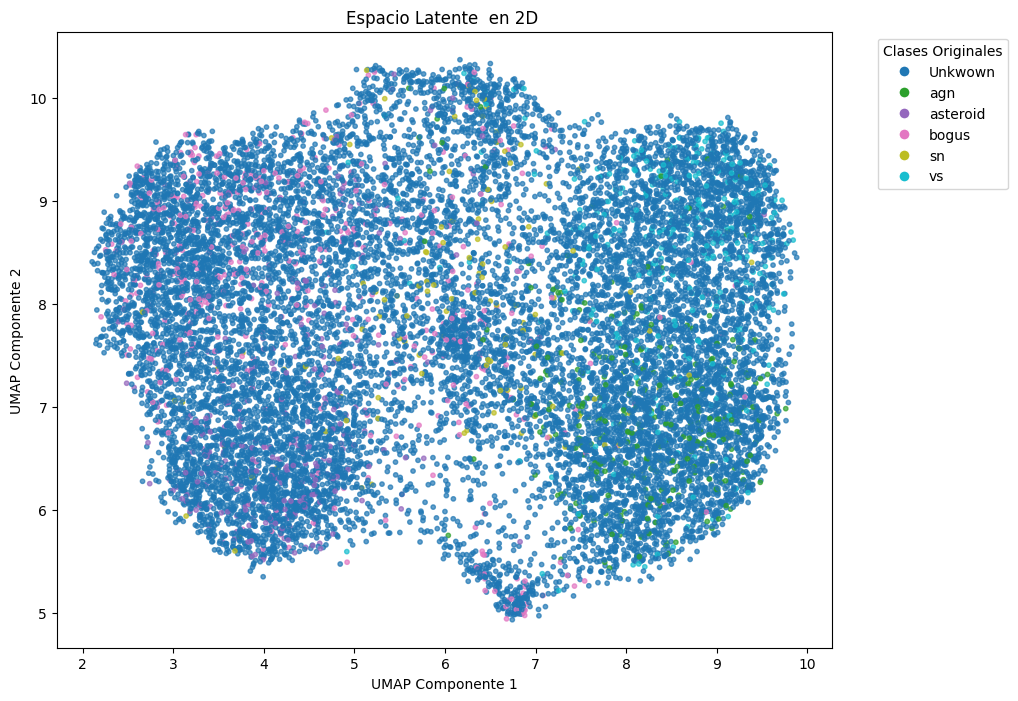

In [194]:
model_ss.eval()



latent_data_ss, labels_data_ss= get_latentspace(model_ss,test_loader,device)

#UMAP

embeding_ss=reducer.fit_transform(latent_data_ss)

#Visualizar el espacio latente
plt.figure(figsize=(10, 8))

scatter = plt.scatter(embeding_ss[:, 0], embeding_ss[:, 1], c=labels_data_ss, cmap='tab10', s=10, alpha=0.7)


labels_unique = np.unique(labels_data_ss)
handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=scatter.cmap(scatter.norm(l)), 
                          markersize=8) for l in labels_unique]
plt.legend(handles=handles, labels=[labels[i] for i in labels_unique],
               title='Clases Originales', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Espacio Latente  en 2D ')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')


Los datos se separan un poco mas pero en general la separacion sigue sin ser buena

In [195]:
#Repetimos pero ahora solo con las muestras etiquetadas 
df_lb=df[df['class_encoded']!=0]
X_lb = torch.from_numpy(np.stack(df_lb['processed_img'].values)).float()
y_lb= torch.from_numpy(df_lb['class_encoded'].values).long()

#Dividimos los datos en train y test estratificando por clase
x_train_lb, x_test_lb, y_train_lb, y_test_lb = train_test_split( X_lb , y_lb , test_size=0.3,stratify=y_lb,random_state=8742)

In [196]:
#Dividimos el train set en train y validation



for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_lb, y_train_lb)):
    
    x_val_lb, y_val_lb = x_train_lb[val_idx], y_train_lb[val_idx]
    x_train_lb, y_train_lb = x_train_lb[train_idx], y_train_lb[train_idx]
    
    
   
    break #usamos solo el primer fold como validation
print(f'Train size: {len(x_train_lb)} , Validation size: {len(x_val_lb)}, Test size: {len(x_test_lb)}')

Train size: 2819 , Validation size: 705, Test size: 1511


In [197]:
#preparamos los datos para el modelo
train_dataset_lb=TensorDataset(x_train_lb,y_train_lb)
val_dataset_lb=TensorDataset(x_val_lb,y_val_lb)
test_dataset_lb=TensorDataset(x_test_lb,y_test_lb)

batch_size=128
train_loader_lb = DataLoader(train_dataset_lb, batch_size=batch_size, shuffle=True)
val_loader_lb   = DataLoader(val_dataset_lb, batch_size=batch_size, shuffle=False)
test_loader_lb  = DataLoader(test_dataset_lb, batch_size=batch_size, shuffle=False)

#configuramos el modelo
model_lb=SS_VAE(n_cls=5).to(device)
optimizer_lb=optim.Adam(model_lb.parameters(), lr=1e-3)

#entrenamos el modelo
epochs=60
train_losses_ss_lb=[]
train_vae_losses_ss_lb=[]
train_clf_losses_ss_lb=[]
val_losses_ss_lb=[]
val_vae_losses_ss_lb=[]
val_clf_losses_ss_lb=[]
for epoch in range(epochs):
    train_loss_lb,train_vae_loss_lb,train_clf_loss_lb=train_epoch_ss(model_lb,train_loader_lb,optimizer_lb,device)
    val_loss_lb,val_vae_loss_lb,val_clf_loss_lb=val_epoch_ss(model_lb,val_loader_lb,device)
    train_losses_ss_lb.append(train_loss_lb)
    val_losses_ss_lb.append(val_loss_lb)
    train_vae_losses_ss.append(train_vae_loss_lb)
    val_vae_losses_ss.append(val_vae_loss_lb)
    train_clf_losses_ss.append(train_clf_loss_lb)
    val_clf_losses_ss.append(val_clf_loss_lb)

    print(f'Epoch: {epoch+1}/{epochs} - '
          f'Train Total Loss: {train_loss_lb:.3f} (VAE: {train_vae_loss_lb:.3f}, CLF: {train_clf_loss_lb:.3f}) - '
          f'Val Total Loss: {val_loss_lb:.3f} (VAE: {val_vae_loss_lb:.3f}, CLF: {val_clf_loss_lb:.3f})')


Epoch: 1/60 - Train Total Loss: 652.596 (VAE: 499.882, CLF: 1.527) - Val Total Loss: 588.904 (VAE: 445.470, CLF: 1.434)
Epoch: 2/60 - Train Total Loss: 528.125 (VAE: 393.685, CLF: 1.344) - Val Total Loss: 477.605 (VAE: 360.895, CLF: 1.167)
Epoch: 3/60 - Train Total Loss: 465.193 (VAE: 351.578, CLF: 1.136) - Val Total Loss: 449.354 (VAE: 342.827, CLF: 1.065)
Epoch: 4/60 - Train Total Loss: 443.682 (VAE: 341.903, CLF: 1.018) - Val Total Loss: 430.528 (VAE: 336.426, CLF: 0.941)
Epoch: 5/60 - Train Total Loss: 432.229 (VAE: 338.810, CLF: 0.934) - Val Total Loss: 421.091 (VAE: 334.709, CLF: 0.864)
Epoch: 6/60 - Train Total Loss: 423.384 (VAE: 337.300, CLF: 0.861) - Val Total Loss: 416.666 (VAE: 334.479, CLF: 0.822)
Epoch: 7/60 - Train Total Loss: 416.120 (VAE: 336.608, CLF: 0.795) - Val Total Loss: 411.502 (VAE: 334.223, CLF: 0.773)
Epoch: 8/60 - Train Total Loss: 411.531 (VAE: 335.425, CLF: 0.761) - Val Total Loss: 406.155 (VAE: 333.789, CLF: 0.724)
Epoch: 9/60 - Train Total Loss: 405.270 

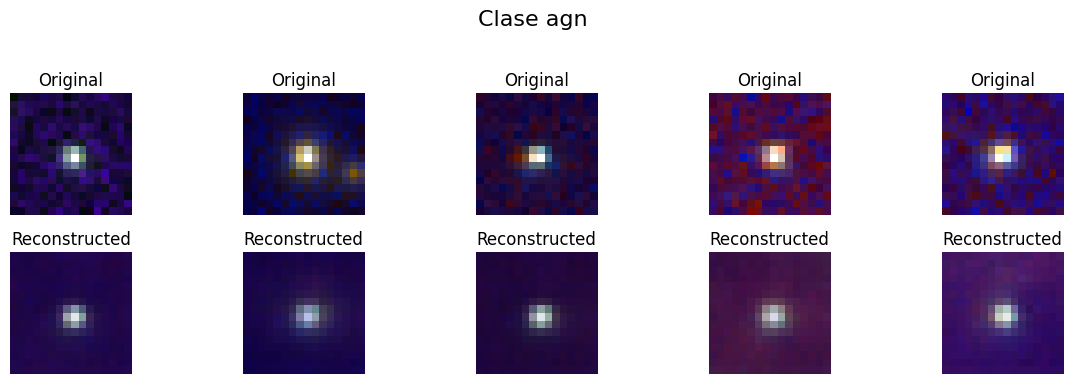

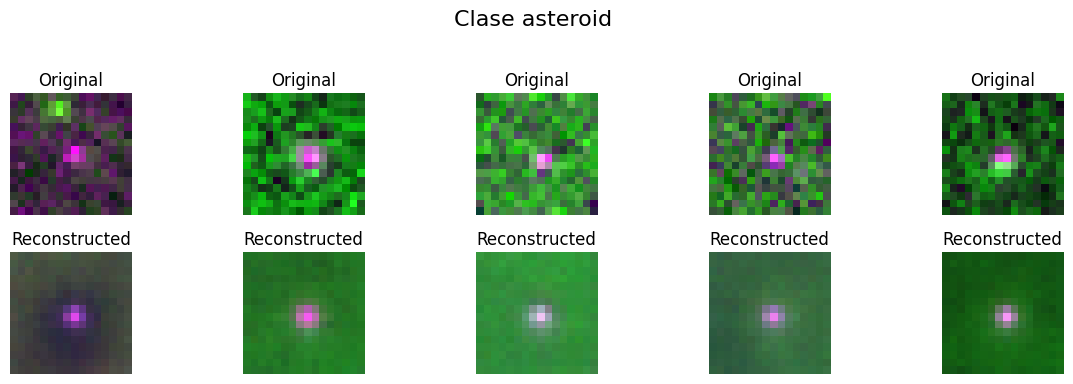

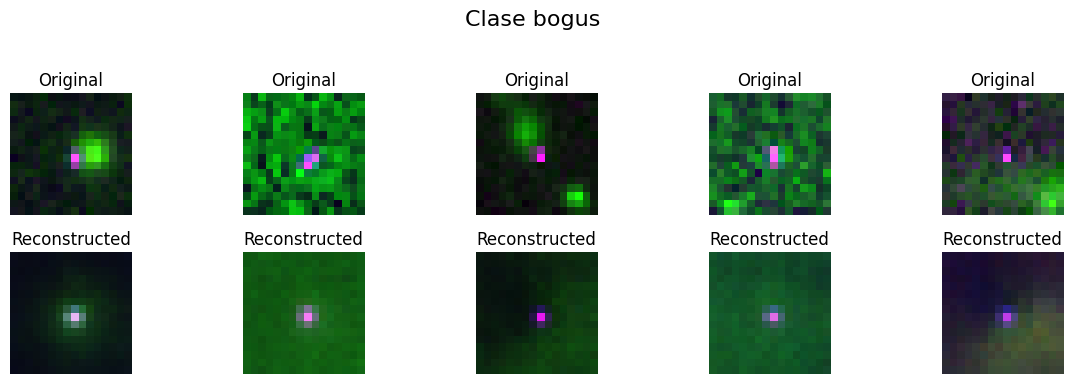

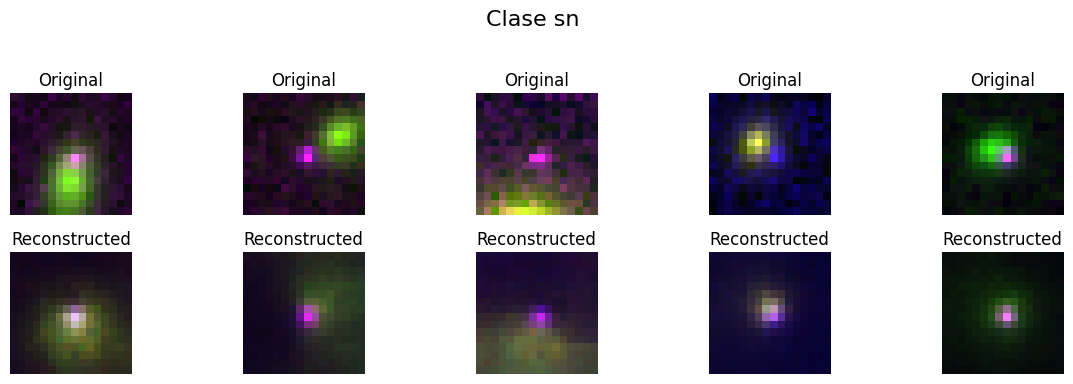

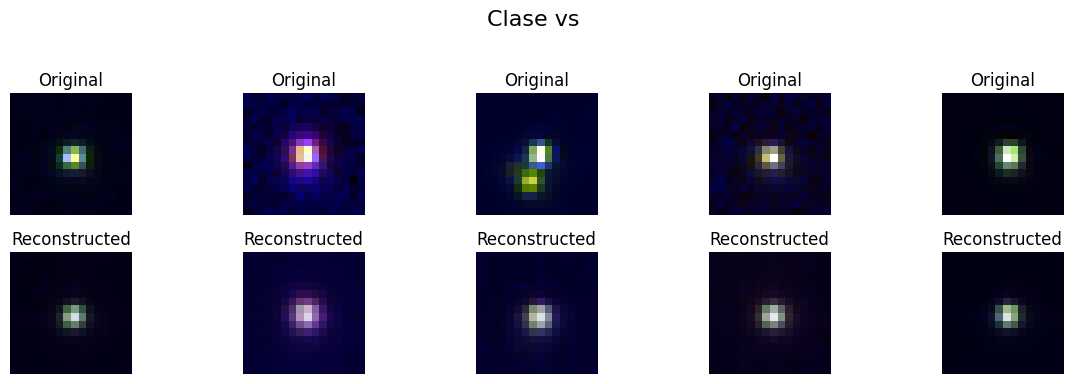


Accuracy en las clases conocidas: 0.8061

Reporte de Clasificación:
              precision    recall  f1-score   support

         agn       0.74      0.91      0.81       291
    asteroid       0.80      0.76      0.78       283
       bogus       0.85      0.86      0.86       498
          sn       0.58      0.55      0.56       116
          vs       0.91      0.76      0.83       323

    accuracy                           0.81      1511
   macro avg       0.78      0.77      0.77      1511
weighted avg       0.81      0.81      0.81      1511


Matriz de Confusión:


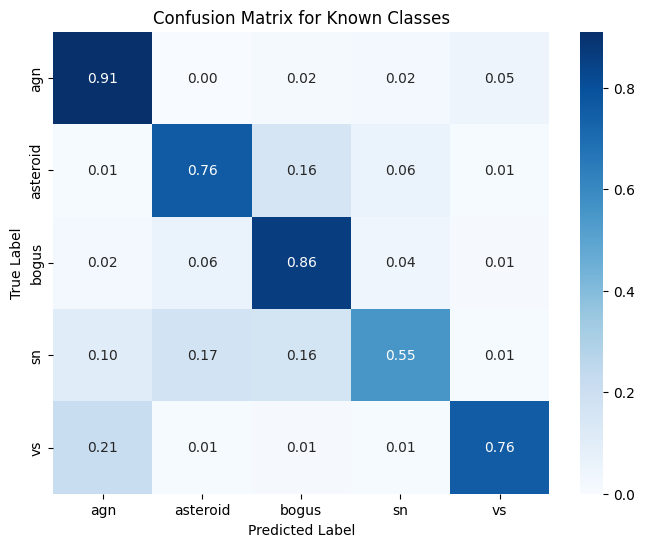

In [198]:

# ---  VISUALIZACIONES PARA EL VAE SEMISUPERVISADO  ---



model_lb.eval()

random.seed(4888)

for clase_code in torch.unique(y_test_lb):
    if clase_code.item() == 0:
        continue

    indices = torch.where(y_test_lb == clase_code)[0]

    
    seleccionados = random.sample(indices.tolist(), 5)

    

    imagenes = x_test_lb[seleccionados].to(device)


    with torch.no_grad():
        recon, _, _, _ = model_lb(imagenes)

    num_imagenes_a_mostrar = len(seleccionados)
    fig, axs = plt.subplots(2, num_imagenes_a_mostrar, figsize=(2.4 * num_imagenes_a_mostrar, 4))
    fig.suptitle(f'Clase {labels[clase_code.item()]} ', fontsize=16)

    for i in range(num_imagenes_a_mostrar):
        img_original_np = imagenes[i].cpu().permute(1, 2, 0).numpy()
        norm_orig = ImageNormalize(img_original_np, interval=MinMaxInterval(), stretch=SqrtStretch())
        if num_imagenes_a_mostrar == 1:
            axs[0].imshow(img_original_np, norm=norm_orig)
            axs[0].axis('off')
            axs[0].set_title('Original')
        else:
            axs[0, i].imshow(img_original_np, norm=norm_orig)
            axs[0, i].axis('off')
            axs[0, i].set_title('Original')

        img_recon_np = recon[i].cpu().permute(1, 2, 0).numpy()
        norm_recon = ImageNormalize(img_recon_np, interval=MinMaxInterval(), stretch=SqrtStretch())
        if num_imagenes_a_mostrar == 1:
            axs[1].imshow(img_recon_np, norm=norm_recon)
            axs[1].axis('off')
            axs[1].set_title('Reconstructed')
        else:
            axs[1, i].imshow(img_recon_np, norm=norm_recon)
            axs[1, i].axis('off')
            axs[1, i].set_title('Reconstructed')

    if num_imagenes_a_mostrar == 1:
        axs[0].set_ylabel("Original", fontsize=12)
        axs[1].set_ylabel("Reconstruido", fontsize=12)
    else:
        axs[0, 0].set_ylabel("Original", fontsize=12)
        axs[1, 0].set_ylabel("Reconstruido", fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns 

# --- Evaluación del clasificador ---


model_lb.eval() 
all_predicted_labels_lb = []
all_true_labels_remapped_lb = []

with torch.no_grad(): 
    for data, labels_batch in test_loader_lb:
        data = data.to(device)
        labels_batch = labels_batch.to(device)

        
        _, _, _, cls = model_lb(data)

        
        labeled_mask = (labels_batch != 0)

        if labeled_mask.sum() > 0: 
            filtered_logits = cls[labeled_mask]
            true_labels_batch = labels_batch[labeled_mask]

            
            remapped_true_labels = (true_labels_batch - 1).long()

            
            predicted_labels = torch.argmax(filtered_logits, dim=1)

            
            all_predicted_labels_lb.extend(predicted_labels.cpu().numpy())
            all_true_labels_remapped_lb.extend(remapped_true_labels.cpu().numpy())


all_predicted_labels_lb = np.array(all_predicted_labels_lb)
all_true_labels_remapped_lb = np.array(all_true_labels_remapped_lb)


classifier_class_names = [labels[i] for i in range(1, len(labels))]

print(f"\nAccuracy en las clases conocidas: {accuracy_score(all_true_labels_remapped_lb, all_predicted_labels_lb):.4f}")

print("\nReporte de Clasificación:")
print(classification_report(all_true_labels_remapped_lb, all_predicted_labels_lb, target_names=classifier_class_names, zero_division=0))

print("\nMatriz de Confusión:")
cm_lb = confusion_matrix(all_true_labels_remapped_lb, all_predicted_labels_lb,normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lb, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classifier_class_names, yticklabels=classifier_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Known Classes')
plt.show()



Las reconstrucciones y las metricas de la clasificacion son buenas

c:\Users\Luciano\Desktop\ASTROINFO\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Text(0, 0.5, 'UMAP Componente 2')

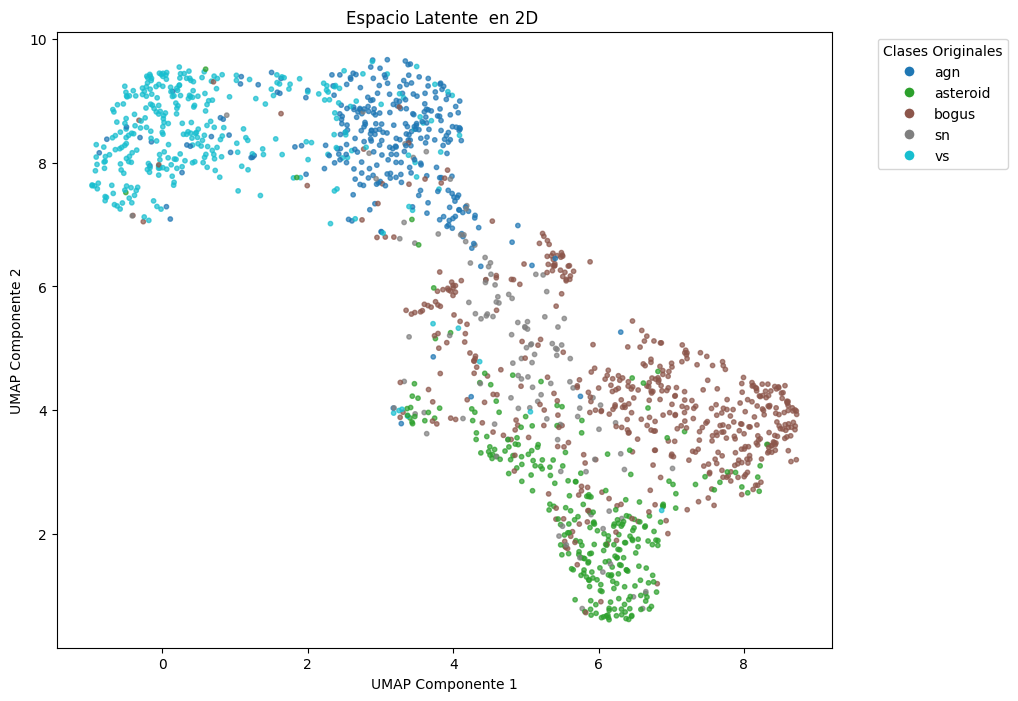

In [199]:
model_lb.eval()



latent_data_lb, labels_data_lb= get_latentspace(model_lb,test_loader_lb,device)

#UMAP

embeding_lb=reducer.fit_transform(latent_data_lb)

#Visualizar el espacio latente
plt.figure(figsize=(10, 8))

scatter = plt.scatter(embeding_lb[:, 0], embeding_lb[:, 1], c=labels_data_lb, cmap='tab10', s=10, alpha=0.7)


labels_unique = np.unique(labels_data_lb)
handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=scatter.cmap(scatter.norm(l)), 
                          markersize=8) for l in labels_unique]
plt.legend(handles=handles, labels=[labels[i] for i in labels_unique],
               title='Clases Originales', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Espacio Latente  en 2D ')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')


Ahora si las clases se agrupan mucho mejor, justamente porque el modelo no se confunde con la clase unknown la cual estaba desvalanceada con respecto a los datos etiquetados, otra forma de resolver este problema es hacer undersampling de los datos no etiquetados para tener un mejor balance entre clases de forma que el modelo aprenda a predecir bien cuando un objeto no es de ninguna de las clases conocidas